In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import time

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    roc_auc_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('paper', font_scale=1.2)

heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets

data = X.copy()
data['num'] = y['num']
data['num_binary'] = data['num'].apply(lambda x: 0 if x == 0 else 1)

# Preprocessing

In [2]:
print("\n=== Duplicates ===")
duplicates = data.duplicated().sum()
print(f"Number of duplicated rows: {duplicates}")


=== Duplicates ===
Number of duplicated rows: 0


In [3]:
print("\n=== Missing Values ===")
missing = data.isnull().sum()
missing_pct = (missing / len(data) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])

for col in ['ca', 'thal']:
    for target_class in data['num_binary'].unique():
        mode_value = data.loc[data['num_binary'] == target_class, col].mode()[0]
        data.loc[(data['num_binary'] == target_class) & (data[col].isnull()), col] = mode_value


=== Missing Values ===
      Missing Count  Missing %
ca                4       1.32
thal              2       0.66


In [4]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

In [5]:
print("Distribusi X:\n", X.count())

Distribusi X:
 age         303
sex         303
cp          303
trestbps    303
chol        303
fbs         303
restecg     303
thalach     303
exang       303
oldpeak     303
slope       303
ca          299
thal        301
dtype: int64


In [6]:
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'ca']
data = pd.get_dummies(data, columns=categorical_cols, prefix=categorical_cols, dtype=int)

In [7]:
# Binary categorical features (sex, fbs, exang) are already 0/1, no encoding needed

In [8]:
X_processed = data.drop(['num', 'num_binary'], axis=1)
y_processed = data['num_binary']

print("Distribusi X:\n", X_processed.count())
print("Distribusi kelas:\n", y_processed.value_counts())

Distribusi X:
 age          303
sex          303
trestbps     303
chol         303
fbs          303
thalach      303
exang        303
oldpeak      303
cp_1         303
cp_2         303
cp_3         303
cp_4         303
restecg_0    303
restecg_1    303
restecg_2    303
slope_1      303
slope_2      303
slope_3      303
thal_3.0     303
thal_6.0     303
thal_7.0     303
ca_0.0       303
ca_1.0       303
ca_2.0       303
ca_3.0       303
dtype: int64
Distribusi kelas:
 num_binary
0    164
1    139
Name: count, dtype: int64


# Modeling


=== RLA Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0191 detik
Waktu Prediksi (Training Set): 0.2448 detik
Waktu Prediksi (Testing Set): 0.0507 detik

Reflex Zones Defined (Automated):
thalach: b'\x97\x00|\x00|\x01k\x00\x00\x00\x00\x00S\x00'
oldpeak: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
exang: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
cp_4: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
slope_2: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
thal_7.0: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'

Training Performance:
Accuracy: 0.8054
Precision: 0.8208
Recall: 0.7373
F1-Score: 0.7768
ROC AUC: 0.8651

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       139
           1       0.82      0.74      0.78       118

    accuracy                           0.81       257
   macro avg       0.81      0.80      0.80       257
weighted avg       0.81      0.81      0

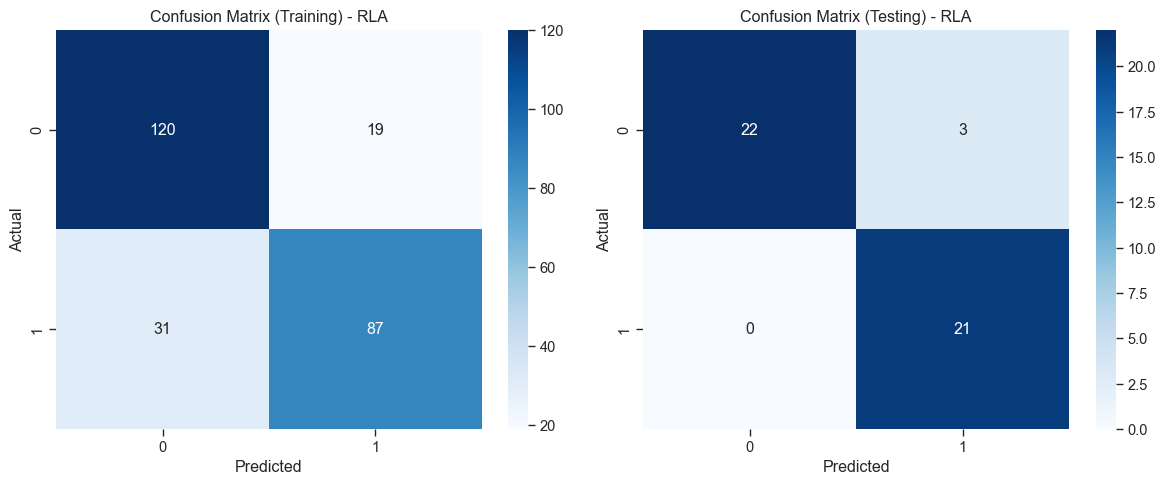

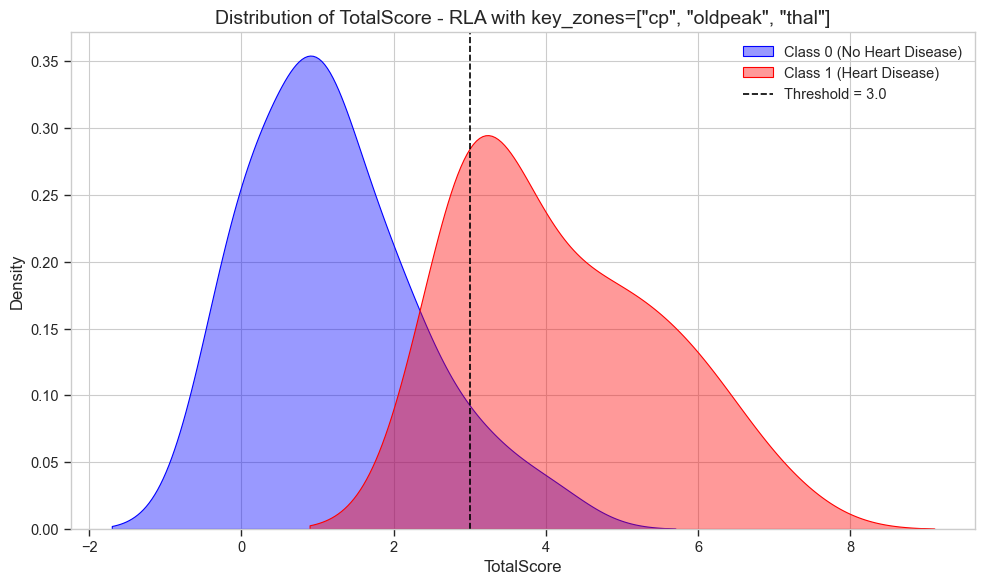

In [ ]:
def define_reflex_zones_automated(X, y, corr_threshold=0.15, prop_threshold=0.35, odds_ratio_threshold=1.5, class_weight=1.0):
    reflex_zones = {}
    correlations = X.corrwith(y)
    class_weighted_corr = correlations * (y.mean() * class_weight + (1 - y.mean()) * (1 - class_weight))

    numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    for feature in numeric_features:
        if abs(class_weighted_corr[feature]) > corr_threshold:
            if class_weighted_corr[feature] > 0:
                threshold = X[feature].quantile(0.75)
                reflex_zones[feature] = lambda x, t=threshold: x > t
            else:
                threshold = X[feature].quantile(0.25)
                reflex_zones[feature] = lambda x, t=threshold: x < t

    categorical_features = [col for col in X.columns if col not in numeric_features]
    for feature in categorical_features:
        if abs(class_weighted_corr[feature]) > corr_threshold:
            prop_class_1 = X.loc[y == 1, feature].mean()
            prop_class_0 = X.loc[y == 0, feature].mean()
            odds_1 = prop_class_1 / (1 - prop_class_1 + 1e-10)
            odds_0 = prop_class_0 / (1 - prop_class_0 + 1e-10)
            odds_ratio = odds_1 / (odds_0 + 1e-10)
            if prop_class_1 > prop_threshold and odds_ratio > odds_ratio_threshold:
                reflex_zones[feature] = lambda x: x == 1

    if not reflex_zones:
        corr_threshold = max(0.10, corr_threshold - 0.05)
        prop_threshold = max(0.25, prop_threshold - 0.05)
        odds_ratio_threshold = max(1.0, odds_ratio_threshold - 0.2)
        for feature in numeric_features:
            if abs(correlations[feature]) > corr_threshold:
                if correlations[feature] > 0:
                    threshold = X[feature].quantile(0.75)
                    reflex_zones[feature] = lambda x, t=threshold: x > t
                else:
                    threshold = X[feature].quantile(0.25)
                    reflex_zones[feature] = lambda x, t=threshold: x < t
        for feature in categorical_features:
            if abs(correlations[feature]) > corr_threshold:
                prop_class_1 = X.loc[y == 1, feature].mean()
                prop_class_0 = X.loc[y == 0, feature].mean()
                odds_1 = prop_class_1 / (1 - prop_class_1 + 1e-10)
                odds_0 = prop_class_0 / (1 - prop_class_0 + 1e-10)
                odds_ratio = odds_1 / (odds_0 + 1e-10)
                if prop_class_1 > prop_threshold and odds_ratio > odds_ratio_threshold:
                    reflex_zones[feature] = lambda x: x == 1

    if not reflex_zones:
        raise ValueError("No reflex zones defined even with loosened thresholds. Check data distribution.")
    return reflex_zones

class ReflexLearningAlgorithm(BaseEstimator, ClassifierMixin):
    def __init__(self, reflex_zones=None, threshold_score=3.0, key_zones=None, key_weight=1.0, min_activation=1):
        self.reflex_zones = reflex_zones
        self.threshold_score = threshold_score
        self.key_zones = key_zones if key_zones is not None else []
        self.key_weight = key_weight
        self.min_activation = min_activation
    
    def fit(self, X, y=None):
        if self.reflex_zones is None:
            self.reflex_zones = define_reflex_zones_automated(X, y)
        self.reflex_zones_ = self.reflex_zones
        return self
    
    def predict(self, X):
        predictions = []
        scores = []
        for i in range(X.shape[0]):
            base_score = sum(1 for feature, condition in self.reflex_zones.items() 
                             if condition(X.iloc[i][feature]))
            key_score = sum(1 for feature, condition in self.reflex_zones.items()
                            if feature in self.key_zones and condition(X.iloc[i][feature])) * self.key_weight
            total_score = base_score + key_score
            active_zones = sum(1 for feature, condition in self.reflex_zones.items() 
                               if condition(X.iloc[i][feature]))
            adjusted_threshold = self.threshold_score - (self.key_weight * 0.4 if active_zones >= self.min_activation else 0)
            scores.append(total_score)
            if total_score >= adjusted_threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        self.scores_ = np.array(scores)  # Ensure scores_ is always updated for the current input
        return np.array(predictions)
    
    def get_params(self, deep=True):
        return {'reflex_zones': self.reflex_zones, 'threshold_score': self.threshold_score, 'key_zones': self.key_zones, 'key_weight': self.key_weight, 'min_activation': self.min_activation}
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

def evaluate_rla(model, X_train, X_test, y_train, y_test, model_name):
    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    training_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred_train = model.predict(X_train)
    train_pred_time = time.perf_counter() - start_time
    y_score_train = model.scores_

    start_time = time.perf_counter()
    y_pred_test = model.predict(X_test)
    test_pred_time = time.perf_counter() - start_time
    y_score_test = model.scores_
    
    print(f"\n=== {model_name} Baseline Model Evaluation ===")
    print(f"\nWaktu Komputasi:")
    print(f"Waktu Pelatihan: {training_time:.4f} detik")
    print(f"Waktu Prediksi (Training Set): {train_pred_time:.4f} detik")
    print(f"Waktu Prediksi (Testing Set): {test_pred_time:.4f} detik")

    print("\nReflex Zones Defined (Automated):")
    for feature, condition in model.reflex_zones_.items():
        print(f"{feature}: {condition.__code__.co_code}")

    roc_auc_train = roc_auc_score(y_train, y_score_train)
    roc_auc_test = roc_auc_score(y_test, y_score_test)

    print("\nTraining Performance:")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
    print(f"F1-Score: {f1_score(y_train, y_pred_train):.4f}")
    print(f"ROC AUC: {roc_auc_train:.4f}")
    print("\nClassification Report (Training):")
    print(classification_report(y_train, y_pred_train))

    print("\nTesting Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
    print(f"ROC AUC: {roc_auc_test:.4f}")
    print("\nClassification Report (Testing):")
    print(classification_report(y_test, y_pred_test))

    cv_scores_acc = cross_val_score(model, X_processed, y_processed, cv=5, scoring='accuracy')

    print("\nCross-Validation (5-Fold) Accuracy:")
    print(f"Scores: {cv_scores_acc.round(4)}")
    print(f"Mean Accuracy: {cv_scores_acc.mean():.4f} ± {cv_scores_acc.std():.4f}")

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Training) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Testing) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Tambahkan kode ini setelah evaluasi model dalam fungsi evaluate_rla
    def plot_total_score_distribution(y_true, y_scores, threshold_score, model_name):
        plt.figure(figsize=(10, 6))
        
        # Pisahkan skor berdasarkan kelas
        scores_class_0 = y_scores[y_true == 0]
        scores_class_1 = y_scores[y_true == 1]
        
        # Plot distribusi menggunakan kernel density plot
        sns.kdeplot(scores_class_0, label='Class 0 (No Heart Disease)', color='blue', fill=True, alpha=0.4)
        sns.kdeplot(scores_class_1, label='Class 1 (Heart Disease)', color='red', fill=True, alpha=0.4)
        
        # Tambahkan garis threshold
        plt.axvline(x=threshold_score, color='black', linestyle='--', label=f'Threshold = {threshold_score}')
        
        # Kustomisasi plot
        plt.title(f'Distribution of TotalScore - {model_name} with key_zones=["cp", "oldpeak", "thal"]', fontsize=14)
        plt.xlabel('TotalScore', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Panggil fungsi ini setelah prediksi dalam evaluate_rla
    plot_total_score_distribution(y_test, y_score_test, rla.threshold_score, "RLA")

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.15, random_state=42, stratify=y_processed
)

rla = ReflexLearningAlgorithm(threshold_score=3.0, key_zones=['cp', 'oldpeak', 'thal'])
evaluate_rla(rla, X_train, X_test, y_train, y_test, model_name="RLA")

# Pembanding

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):

    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    training_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred_train = model.predict(X_train)
    train_pred_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred_test = model.predict(X_test)
    test_pred_time = time.perf_counter() - start_time
    
    print(f"\n=== {model_name} Baseline Model Evaluation ===")
    print(f"\nWaktu Komputasi:")
    print(f"Waktu Pelatihan: {training_time:.4f} detik")
    print(f"Waktu Prediksi (Training Set): {train_pred_time:.4f} detik")
    print(f"Waktu Prediksi (Testing Set): {test_pred_time:.4f} detik")

    print("\nTraining Performance:")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
    print(f"F1-Score: {f1_score(y_train, y_pred_train):.4f}")
    print("\nClassification Report (Training):")
    print(classification_report(y_train, y_pred_train))

    print("\nTesting Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
    print("\nClassification Report (Testing):")
    print(classification_report(y_test, y_pred_test))

    cv_scores = cross_val_score(model, X_processed, y_processed, cv=5, scoring='accuracy')
    print("\nCross-Validation (5-Fold) Accuracy:")
    print(f"Scores: {cv_scores.round(4)}")
    print(f"Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Training) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Testing) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    if hasattr(model, 'predict_proba'):
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = model.decision_function(X_train)
        y_pred_proba_test = model.decision_function(X_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.4f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_train, precision_train, label='Train Precision-Recall')
    plt.plot(recall_test, precision_test, label='Test Precision-Recall')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_processed, y_processed, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Accuracy')
    plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                     train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1)
    plt.fill_between(train_sizes, test_scores.mean(axis=1) - test_scores.std(axis=1),
                     test_scores.mean(axis=1) + test_scores.std(axis=1), alpha=0.1)
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
        print(f"\nFeature Importance ({model_name}):")
        for feature, importance in feature_importance.sort_values(ascending=False).items():
            print(f"{feature}: {importance:.4f}")
        plt.figure(figsize=(10, 6))
        feature_importance.sort_values(ascending=False).plot(kind='bar')
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()
    elif hasattr(model, 'coef_'):
        feature_coefficients = pd.Series(model.coef_[0], index=X_train.columns)
        print(f"\nFeature Coefficients ({model_name}):")
        for feature, coef in feature_coefficients.sort_values(ascending=False).items():
            print(f"{feature}: {coef:.4f}")
        plt.figure(figsize=(10, 6))
        feature_coefficients.sort_values(ascending=False).plot(kind='bar')
        plt.title(f'Feature Coefficients - {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Coefficient')
        plt.tight_layout()
        plt.show()

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.15, random_state=42, stratify=y_processed
)

## Decision Tree


=== Decision Tree Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0058 detik
Waktu Prediksi (Training Set): 0.0022 detik
Waktu Prediksi (Testing Set): 0.0023 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       139
           1       1.00      1.00      1.00       118

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Performance:
Accuracy: 0.7174
Precision: 0.6538
Recall: 0.8095
F1-Score: 0.7234

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.80      0.64      0.71        25
           1       0.65      0.81      0.72        21

    accuracy                           0.72        46
   macro avg       0.73

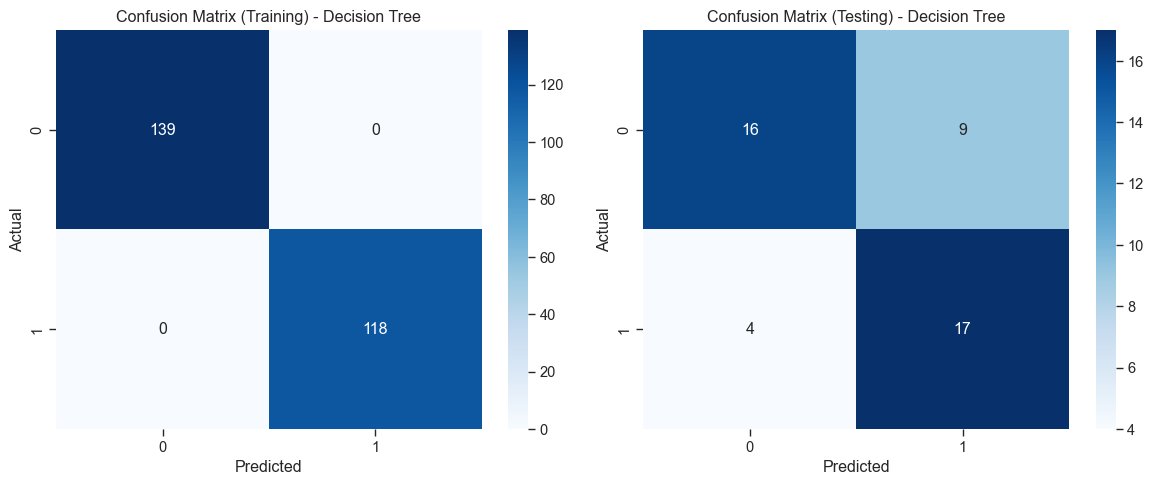

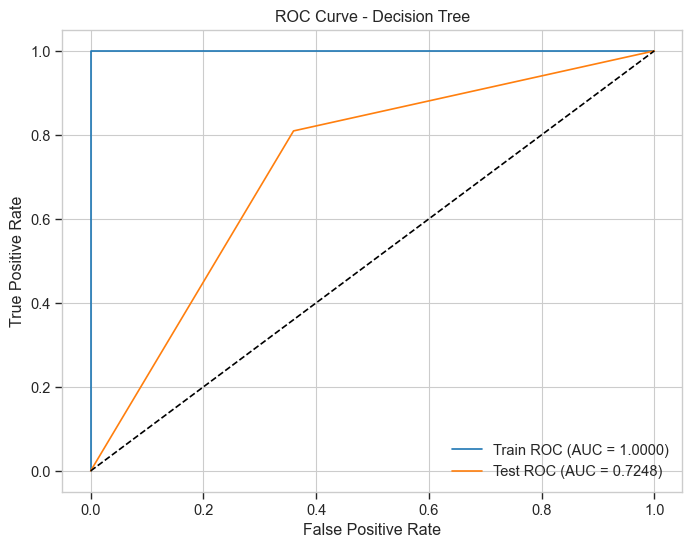

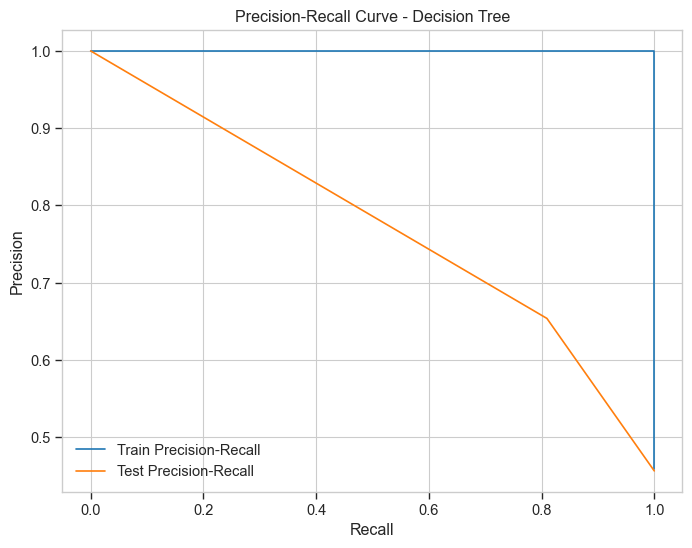

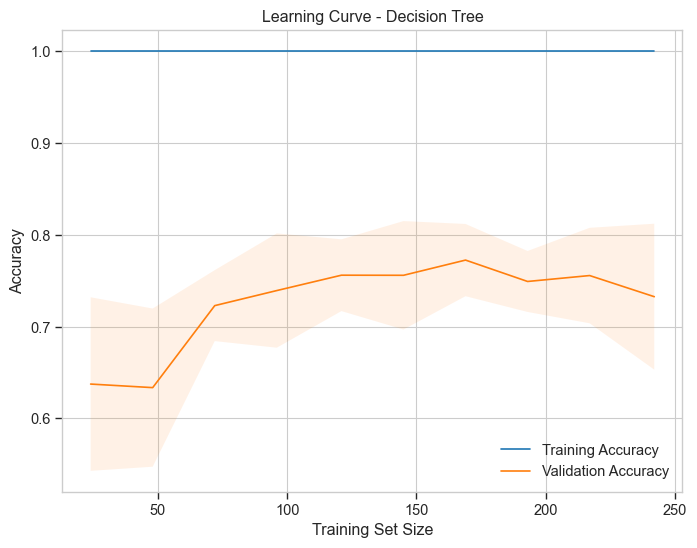


Feature Importance (Decision Tree):
thal_3.0: 0.3145
chol: 0.1254
ca_0.0: 0.1202
cp_4: 0.1168
age: 0.1001
oldpeak: 0.0602
thalach: 0.0569
exang: 0.0248
sex: 0.0227
cp_3: 0.0183
cp_2: 0.0117
fbs: 0.0104
slope_1: 0.0084
thal_7.0: 0.0079
trestbps: 0.0017
ca_2.0: 0.0000
ca_1.0: 0.0000
thal_6.0: 0.0000
restecg_0: 0.0000
slope_3: 0.0000
slope_2: 0.0000
restecg_2: 0.0000
restecg_1: 0.0000
cp_1: 0.0000
ca_3.0: 0.0000


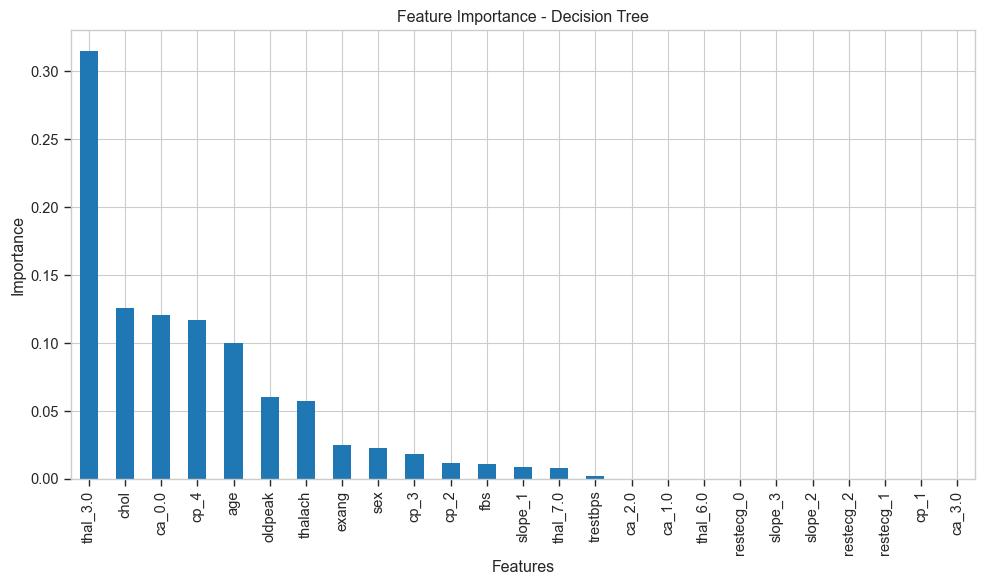

In [11]:
# --- Decision Tree Baseline ---
dt_model = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_model, X_train, X_test, y_train, y_test, 'Decision Tree')

## Logistic Regression

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/


=== Logistic Regression Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1585 detik
Waktu Prediksi (Training Set): 0.0022 detik
Waktu Prediksi (Testing Set): 0.0013 detik

Training Performance:
Accuracy: 0.8755
Precision: 0.8981
Recall: 0.8220
F1-Score: 0.8584

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       139
           1       0.90      0.82      0.86       118

    accuracy                           0.88       257
   macro avg       0.88      0.87      0.87       257
weighted avg       0.88      0.88      0.87       257


Testing Performance:
Accuracy: 0.8261
Precision: 0.7826
Recall: 0.8571
F1-Score: 0.8182

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        25
           1       0.78      0.86      0.82        21

    accuracy                           0.83        46
   macro avg     

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/


Cross-Validation (5-Fold) Accuracy:
Scores: [0.8852 0.8852 0.8361 0.85   0.7833]
Mean Accuracy: 0.8480 ± 0.0377


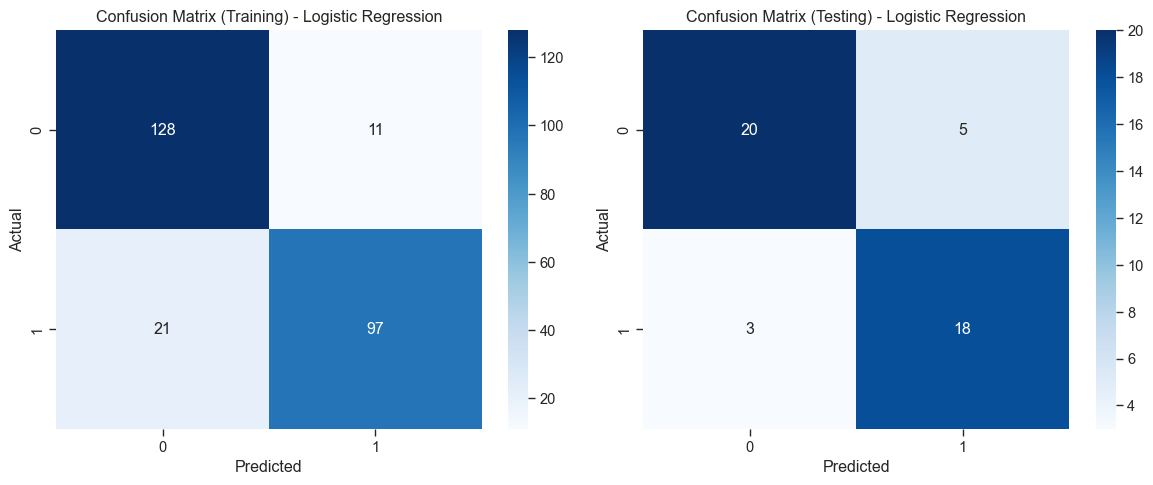

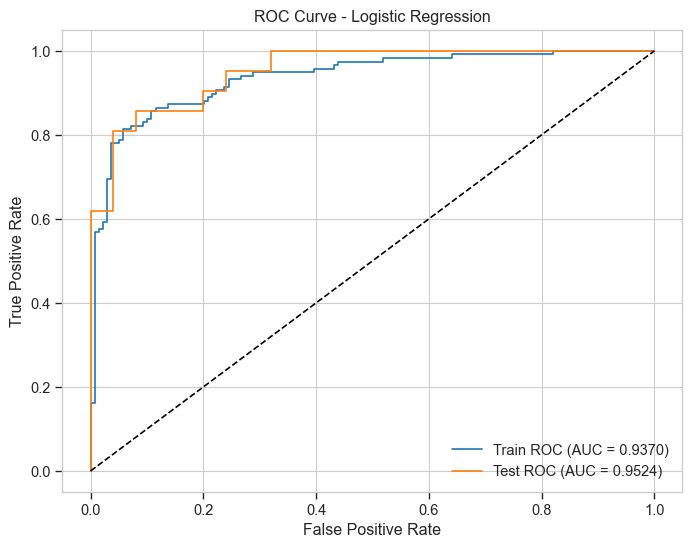

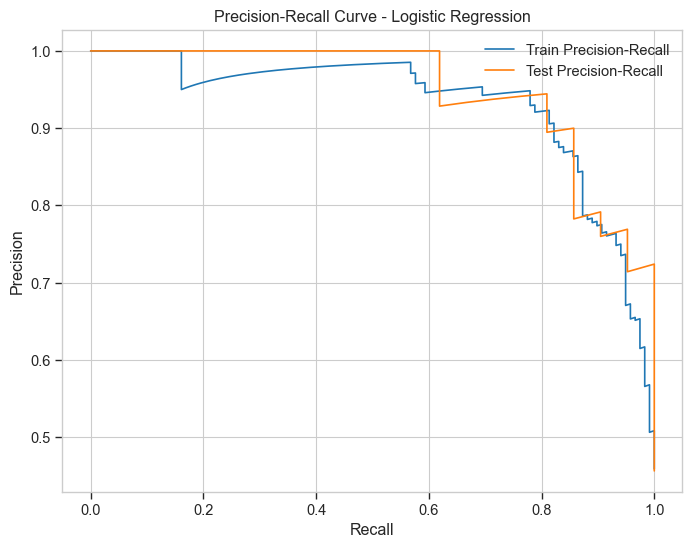

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

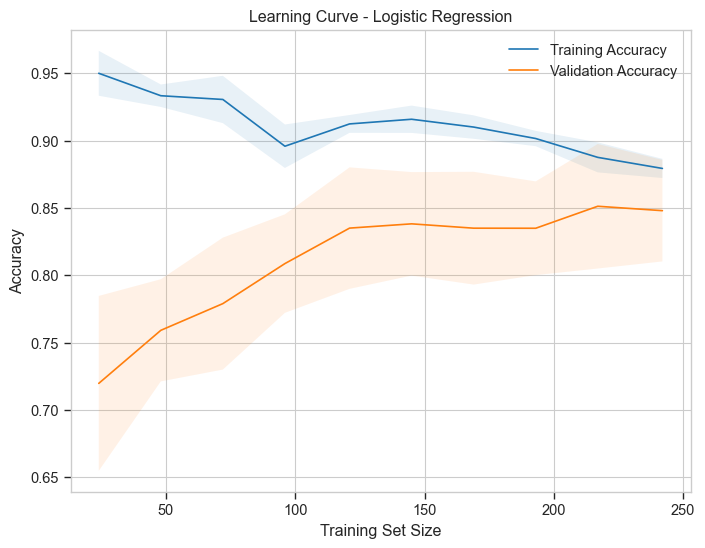


Feature Coefficients (Logistic Regression):
sex: 1.2141
thal_7.0: 1.0423
cp_4: 1.0085
ca_2.0: 0.6966
slope_2: 0.5355
exang: 0.4663
ca_3.0: 0.4573
ca_1.0: 0.3900
oldpeak: 0.2608
restecg_2: 0.1962
cp_2: 0.1001
trestbps: 0.0167
chol: 0.0057
age: -0.0081
thalach: -0.0163
restecg_1: -0.0247
slope_3: -0.1153
fbs: -0.1619
restecg_0: -0.1847
slope_1: -0.4334
thal_6.0: -0.4865
cp_3: -0.5552
cp_1: -0.5665
thal_3.0: -0.5690
ca_0.0: -1.5571


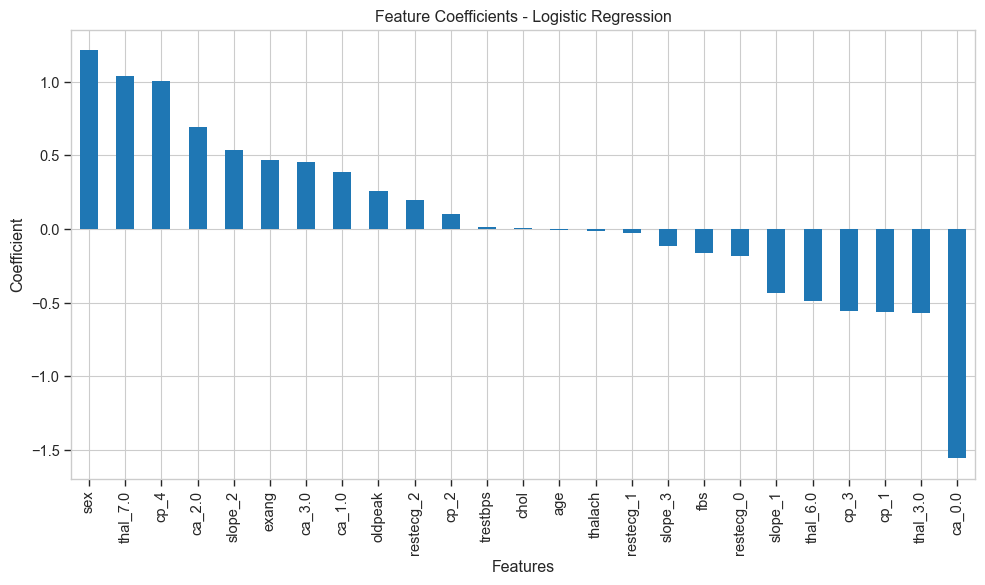

In [12]:
# --- Logistic Regression Baseline ---
lr_model = LogisticRegression(random_state=42, max_iter=1000)
evaluate_model(lr_model, X_train, X_test, y_train, y_test, 'Logistic Regression')

## KNN


=== k-Nearest Neighbors Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0034 detik
Waktu Prediksi (Training Set): 1.9301 detik
Waktu Prediksi (Testing Set): 0.0089 detik

Training Performance:
Accuracy: 0.7354
Precision: 0.7273
Recall: 0.6780
F1-Score: 0.7018

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       139
           1       0.73      0.68      0.70       118

    accuracy                           0.74       257
   macro avg       0.73      0.73      0.73       257
weighted avg       0.73      0.74      0.73       257


Testing Performance:
Accuracy: 0.7826
Precision: 0.9231
Recall: 0.5714
F1-Score: 0.7059

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        25
           1       0.92      0.57      0.71        21

    accuracy                           0.78        46
   macro avg     

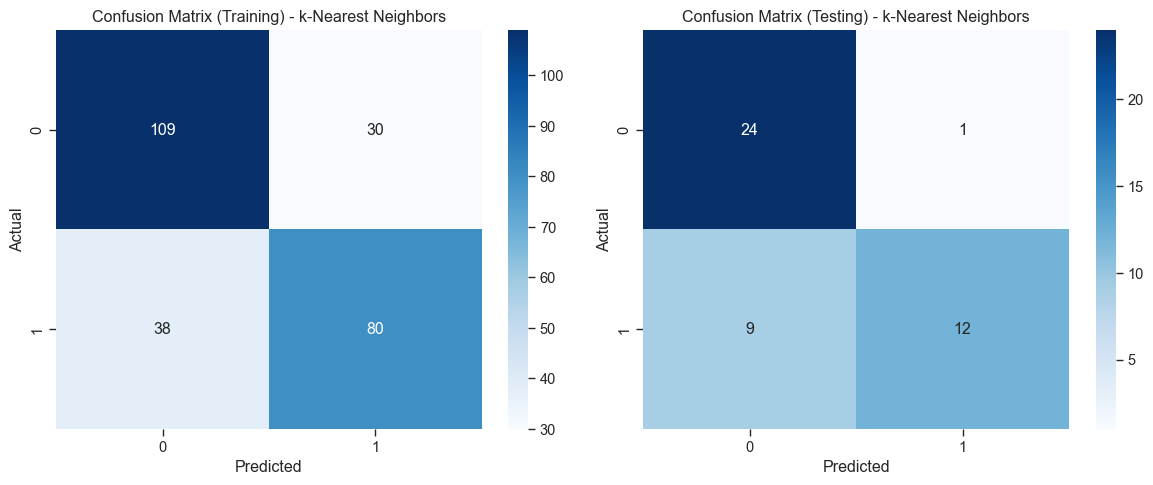

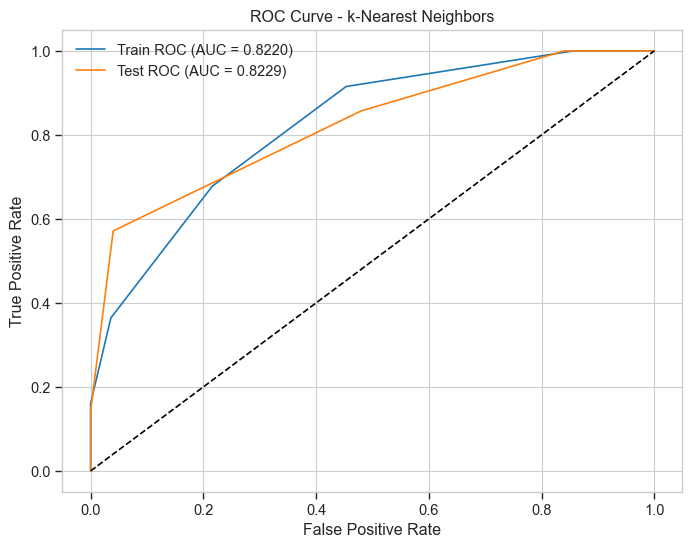

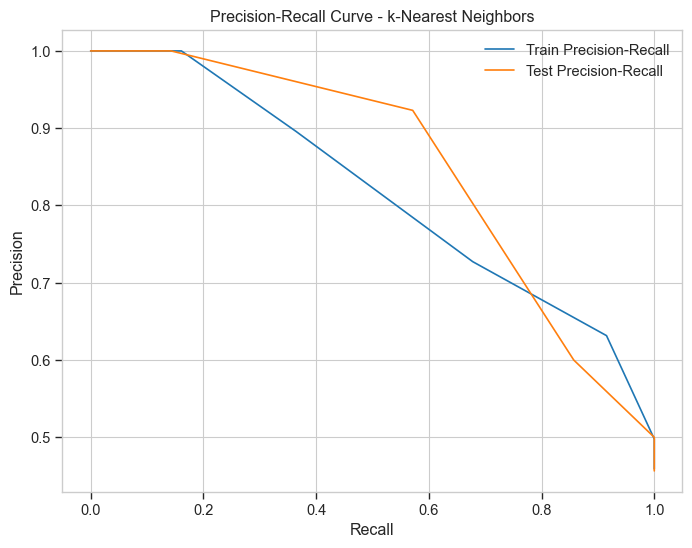

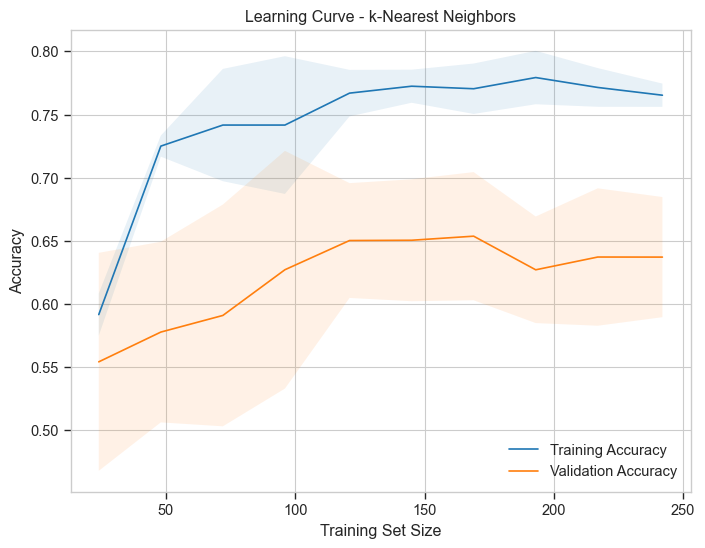

In [13]:
# --- k-Nearest Neighbors Baseline ---
knn_model = KNeighborsClassifier()
evaluate_model(knn_model, X_train, X_test, y_train, y_test, 'k-Nearest Neighbors')

## Naive Bayes


=== Naive Bayes Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0026 detik
Waktu Prediksi (Training Set): 0.0013 detik
Waktu Prediksi (Testing Set): 0.0012 detik

Training Performance:
Accuracy: 0.8444
Precision: 0.8611
Recall: 0.7881
F1-Score: 0.8230

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       139
           1       0.86      0.79      0.82       118

    accuracy                           0.84       257
   macro avg       0.85      0.84      0.84       257
weighted avg       0.85      0.84      0.84       257


Testing Performance:
Accuracy: 0.8696
Precision: 0.8261
Recall: 0.9048
F1-Score: 0.8636

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        25
           1       0.83      0.90      0.86        21

    accuracy                           0.87        46
   macro avg       0.87  

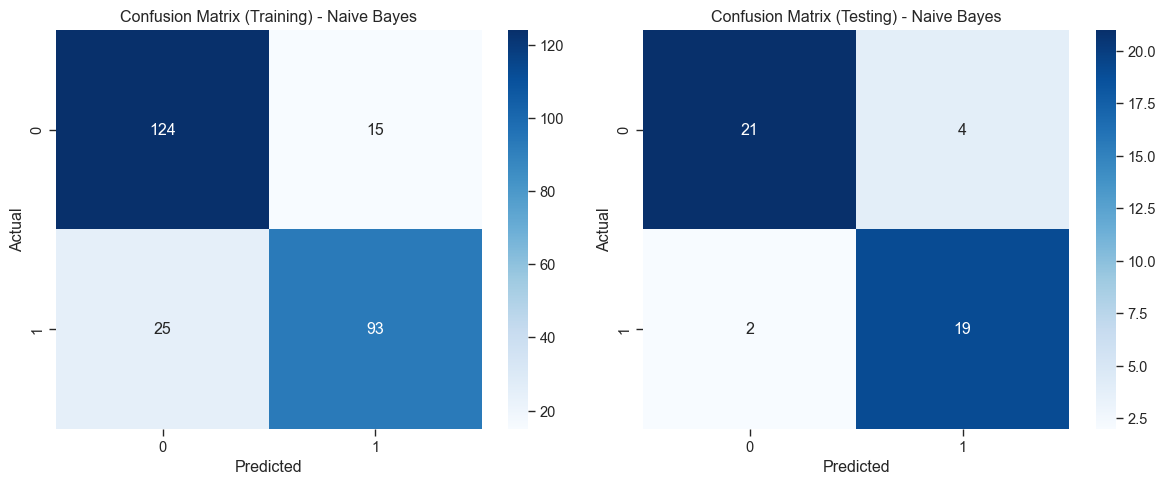

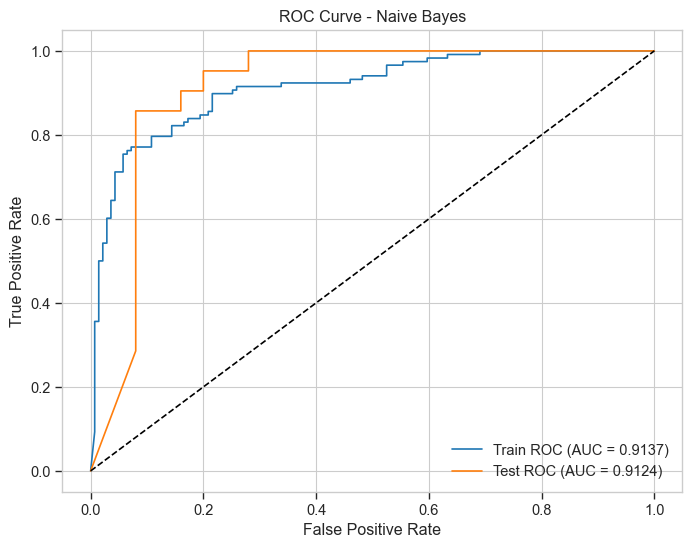

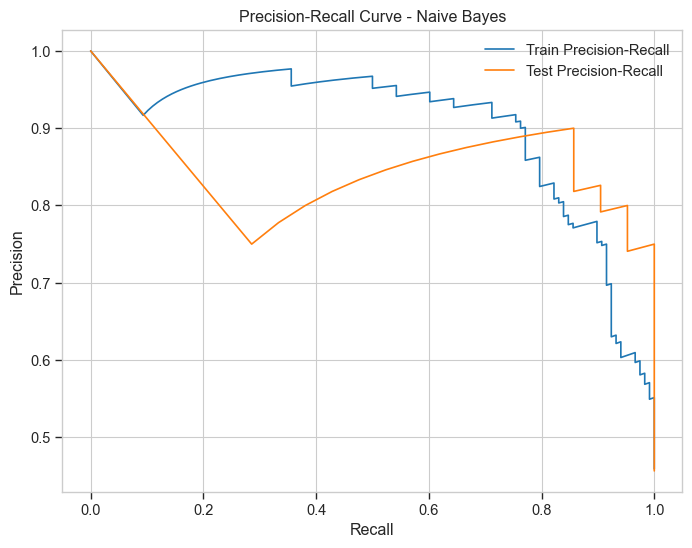

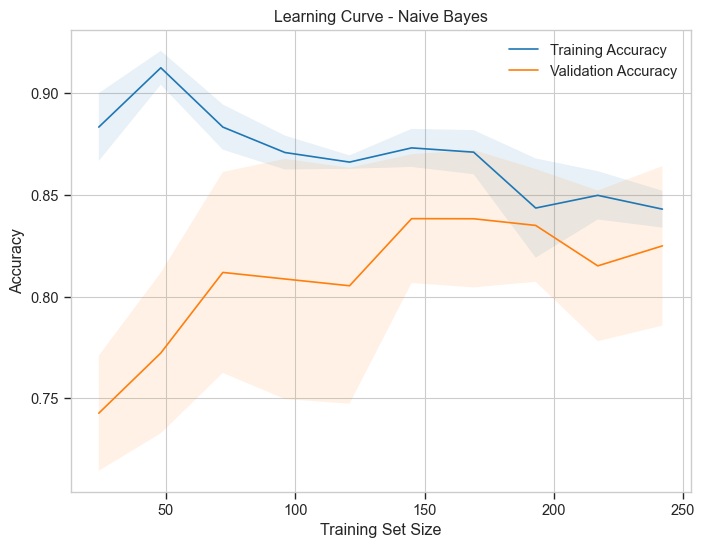

In [14]:
# --- Naive Bayes Baseline ---
nb_model = GaussianNB()
evaluate_model(nb_model, X_train, X_test, y_train, y_test, 'Naive Bayes')

## Support Vector Machine


=== Support Vector Machine Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0287 detik
Waktu Prediksi (Training Set): 0.0117 detik
Waktu Prediksi (Testing Set): 0.0035 detik

Training Performance:
Accuracy: 0.6498
Precision: 0.7000
Recall: 0.4153
F1-Score: 0.5213

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.63      0.85      0.72       139
           1       0.70      0.42      0.52       118

    accuracy                           0.65       257
   macro avg       0.67      0.63      0.62       257
weighted avg       0.66      0.65      0.63       257


Testing Performance:
Accuracy: 0.7391
Precision: 0.8000
Recall: 0.5714
F1-Score: 0.6667

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        25
           1       0.80      0.57      0.67        21

    accuracy                           0.74        46
   macro avg  

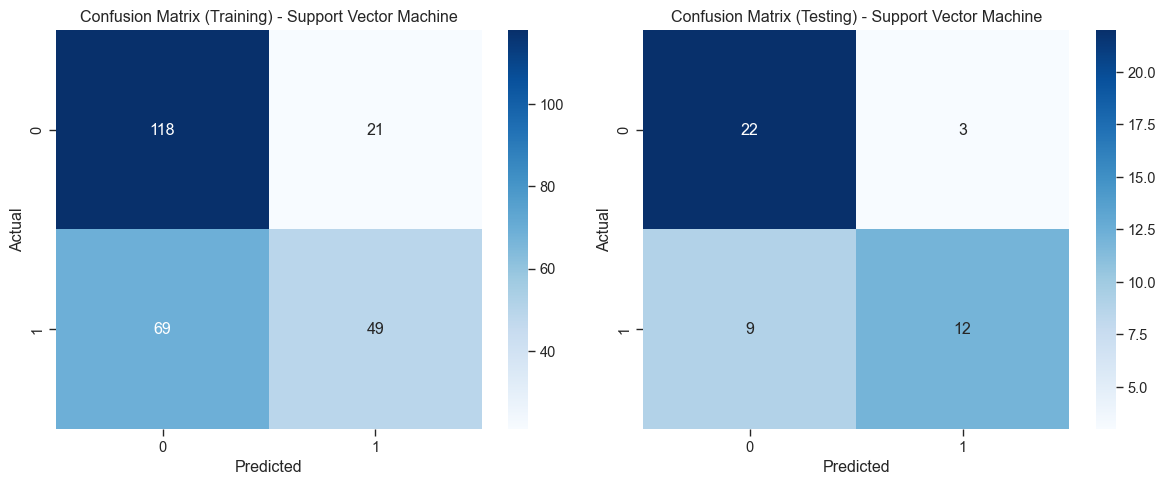

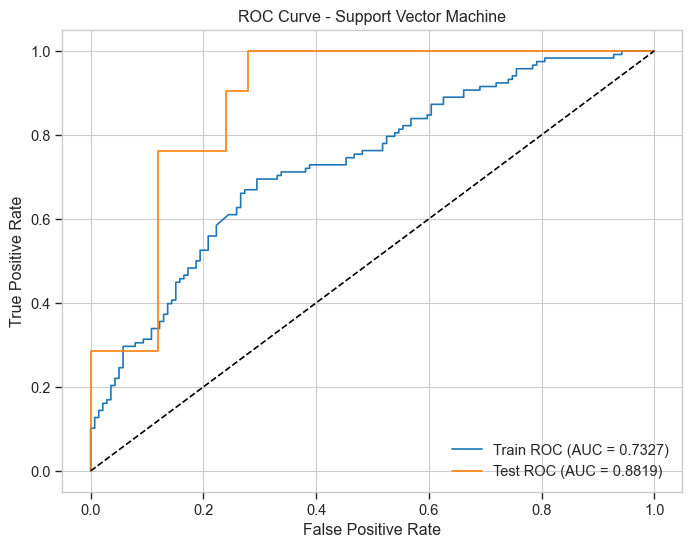

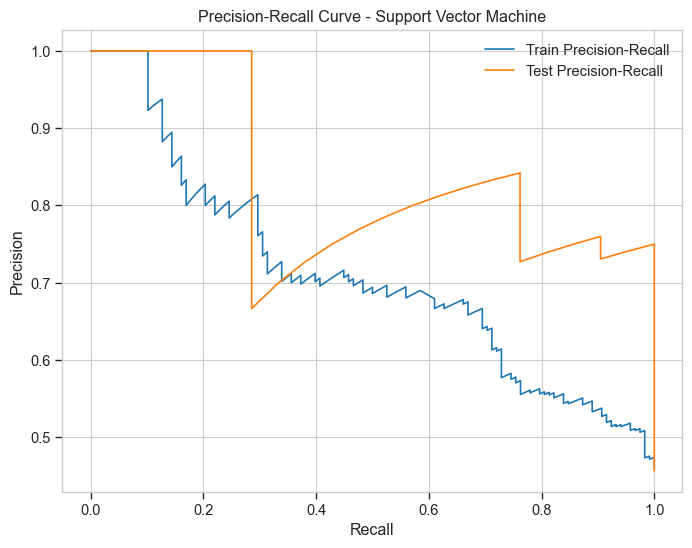

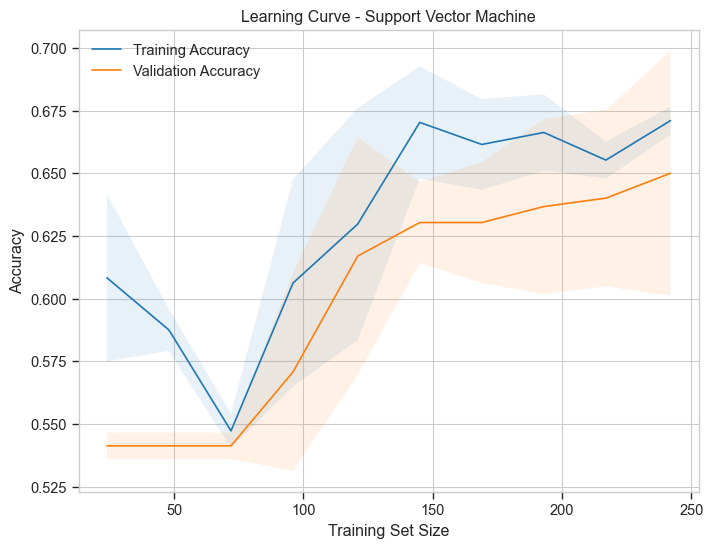

In [15]:
# --- Support Vector Machine Baseline ---
svm_model = SVC(probability=True, random_state=42)
evaluate_model(svm_model, X_train, X_test, y_train, y_test, 'Support Vector Machine')

## Random Forest


=== Random Forest Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1843 detik
Waktu Prediksi (Training Set): 0.0111 detik
Waktu Prediksi (Testing Set): 0.0086 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       139
           1       1.00      1.00      1.00       118

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Performance:
Accuracy: 0.8913
Precision: 0.8333
Recall: 0.9524
F1-Score: 0.8889

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        25
           1       0.83      0.95      0.89        21

    accuracy                           0.89        46
   macro avg       0.89

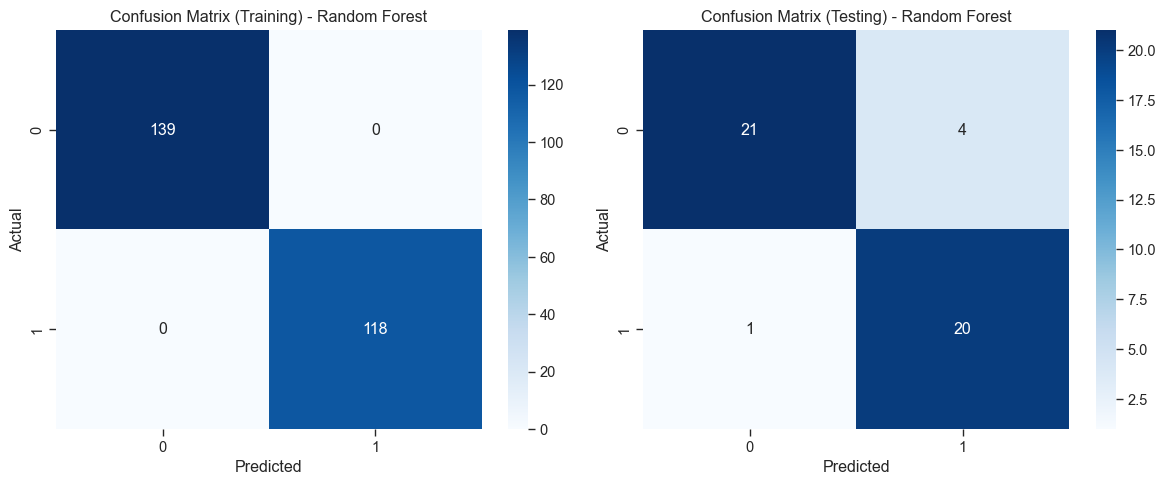

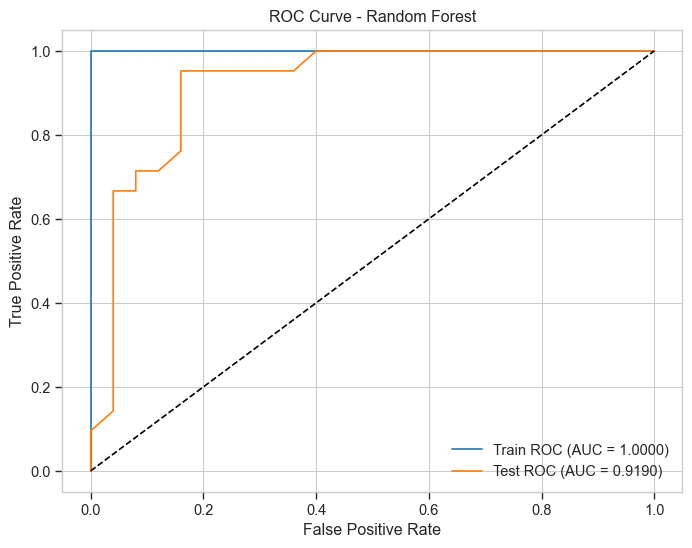

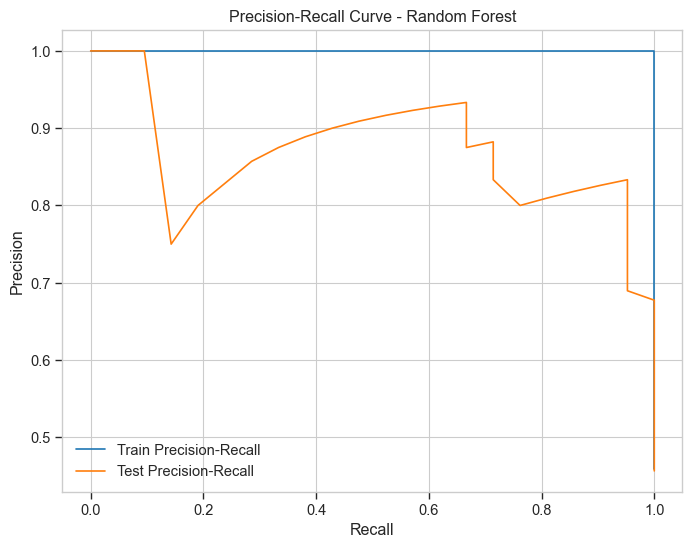

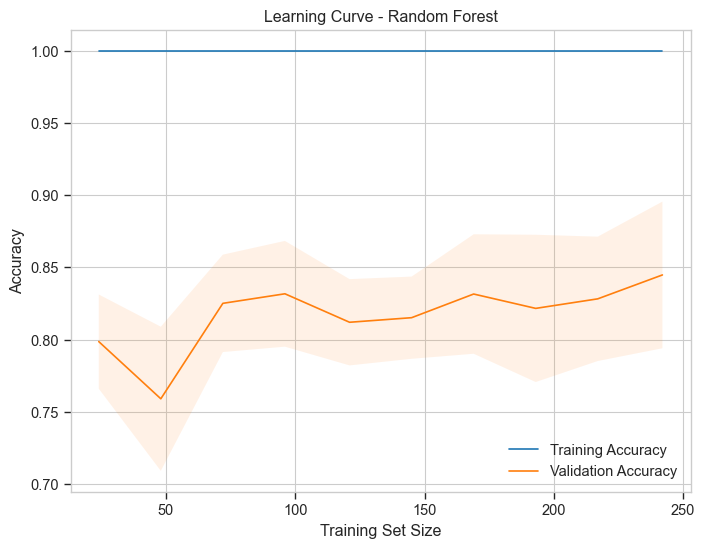


Feature Importance (Random Forest):
thal_3.0: 0.1307
thalach: 0.0885
thal_7.0: 0.0884
oldpeak: 0.0815
ca_0.0: 0.0799
chol: 0.0751
age: 0.0677
trestbps: 0.0635
cp_4: 0.0600
exang: 0.0482
slope_1: 0.0324
sex: 0.0305
cp_3: 0.0224
cp_1: 0.0170
ca_1.0: 0.0165
slope_2: 0.0155
ca_2.0: 0.0144
restecg_0: 0.0137
restecg_2: 0.0127
cp_2: 0.0124
ca_3.0: 0.0094
fbs: 0.0093
thal_6.0: 0.0063
slope_3: 0.0039
restecg_1: 0.0000


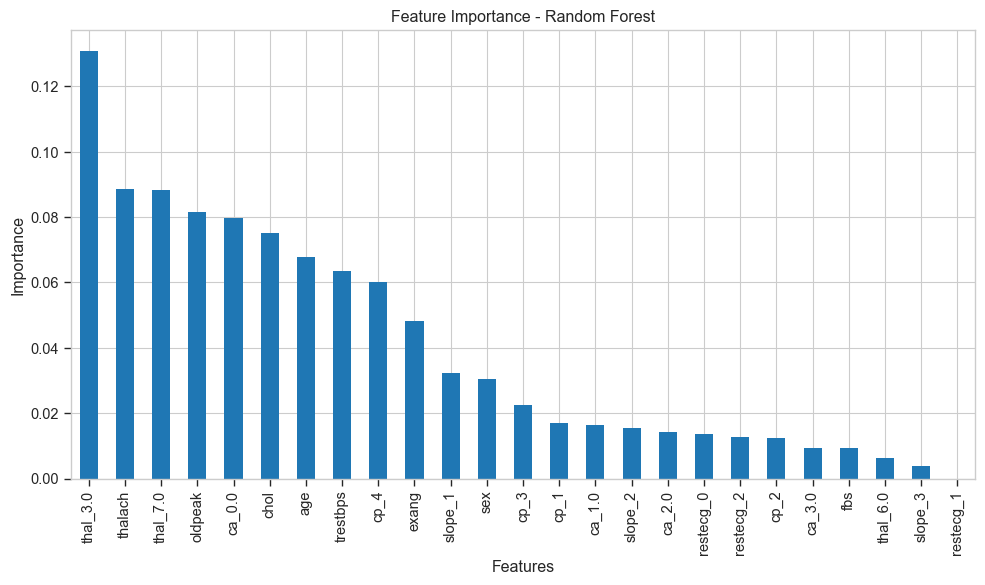

In [16]:
# --- Random Forest Baseline ---
rf_model = RandomForestClassifier(random_state=42)
evaluate_model(rf_model, X_train, X_test, y_train, y_test, 'Random Forest')

## Gradient Boosting


=== Gradient Boosting Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1620 detik
Waktu Prediksi (Training Set): 0.0024 detik
Waktu Prediksi (Testing Set): 0.0016 detik

Training Performance:
Accuracy: 0.9961
Precision: 1.0000
Recall: 0.9915
F1-Score: 0.9957

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       139
           1       1.00      0.99      1.00       118

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Performance:
Accuracy: 0.8261
Precision: 0.7826
Recall: 0.8571
F1-Score: 0.8182

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        25
           1       0.78      0.86      0.82        21

    accuracy                           0.83        46
   macro avg       

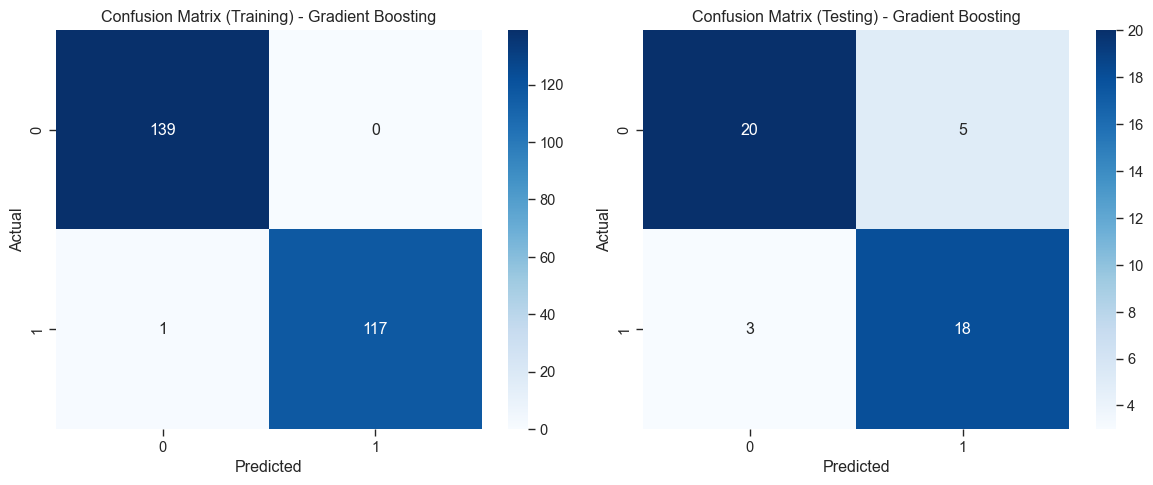

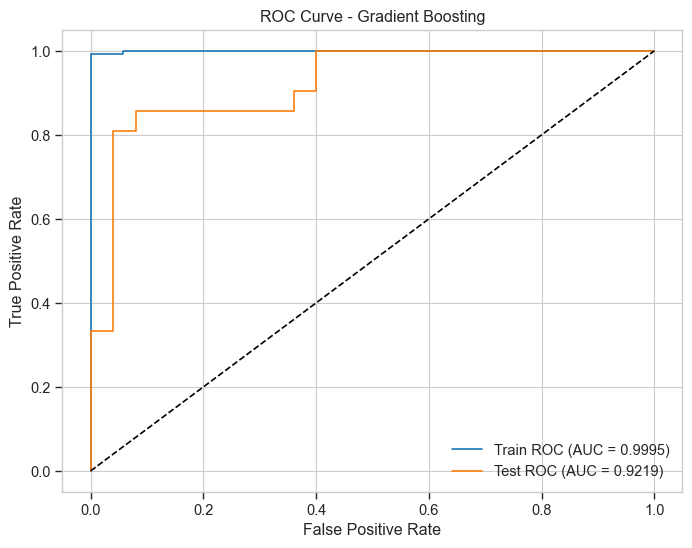

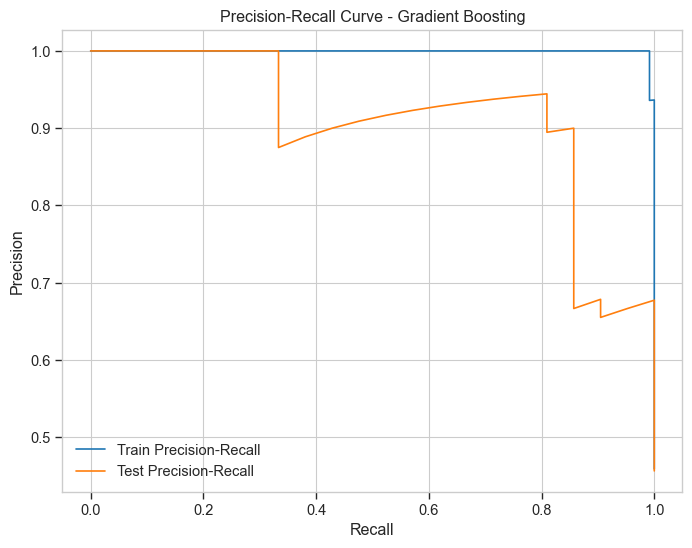

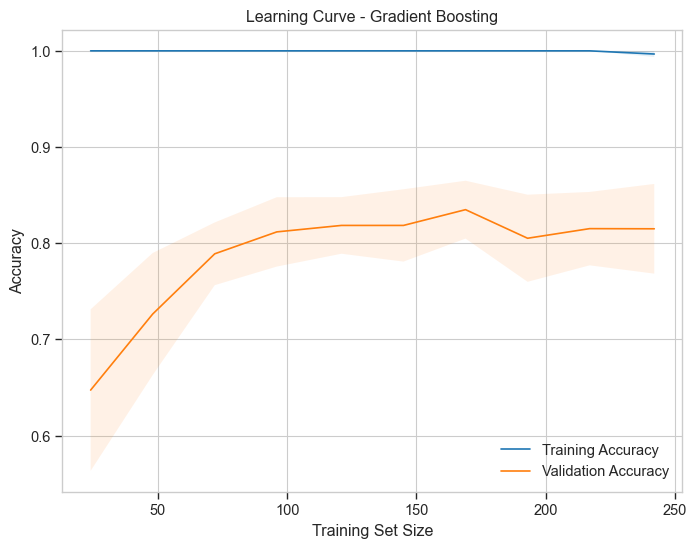


Feature Importance (Gradient Boosting):
thal_7.0: 0.1580
thal_3.0: 0.1561
ca_0.0: 0.1391
cp_4: 0.1217
age: 0.0788
chol: 0.0669
oldpeak: 0.0664
thalach: 0.0562
sex: 0.0384
trestbps: 0.0352
slope_2: 0.0144
cp_1: 0.0106
cp_3: 0.0101
ca_3.0: 0.0092
restecg_0: 0.0081
exang: 0.0079
cp_2: 0.0071
slope_1: 0.0064
ca_1.0: 0.0034
slope_3: 0.0023
ca_2.0: 0.0019
restecg_2: 0.0017
thal_6.0: 0.0002
restecg_1: 0.0000
fbs: 0.0000


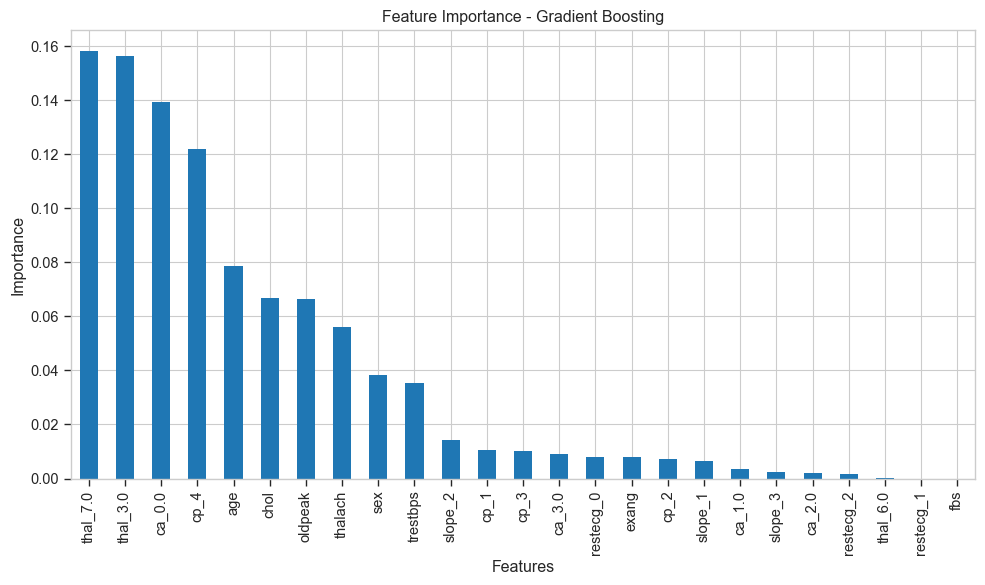

In [17]:
# --- Gradient Boosting Baseline ---
gb_model = GradientBoostingClassifier(random_state=42)
evaluate_model(gb_model, X_train, X_test, y_train, y_test, 'Gradient Boosting')

## AdaBoost


=== AdaBoost Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1109 detik
Waktu Prediksi (Training Set): 0.0200 detik
Waktu Prediksi (Testing Set): 0.0155 detik

Training Performance:
Accuracy: 0.8794
Precision: 0.8783
Recall: 0.8559
F1-Score: 0.8670

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       139
           1       0.88      0.86      0.87       118

    accuracy                           0.88       257
   macro avg       0.88      0.88      0.88       257
weighted avg       0.88      0.88      0.88       257


Testing Performance:
Accuracy: 0.8696
Precision: 0.8261
Recall: 0.9048
F1-Score: 0.8636

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.91      0.84      0.88        25
           1       0.83      0.90      0.86        21

    accuracy                           0.87        46
   macro avg       0.87     

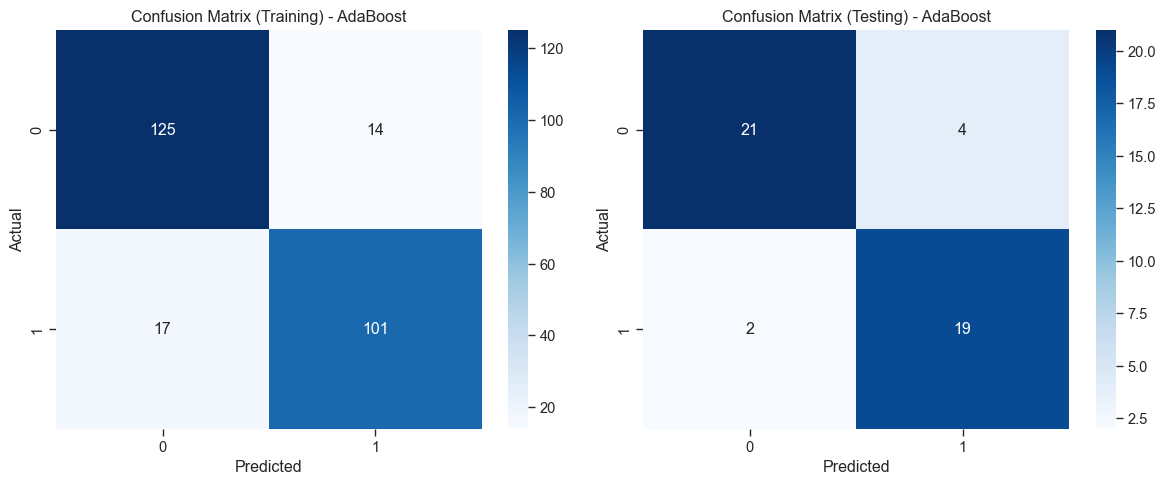

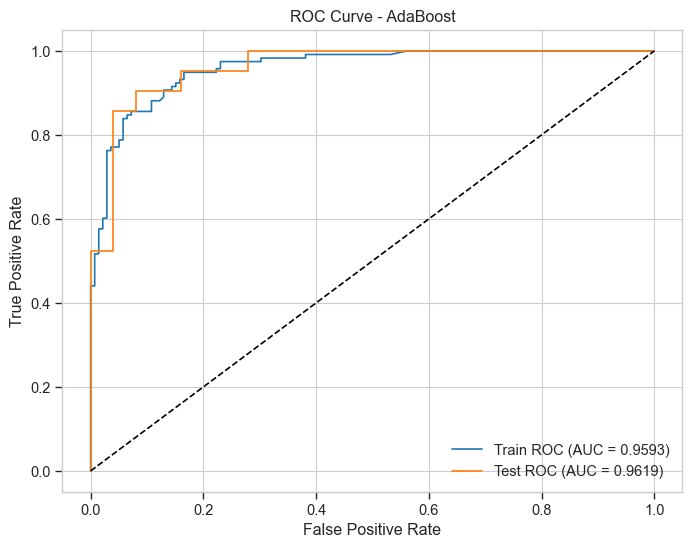

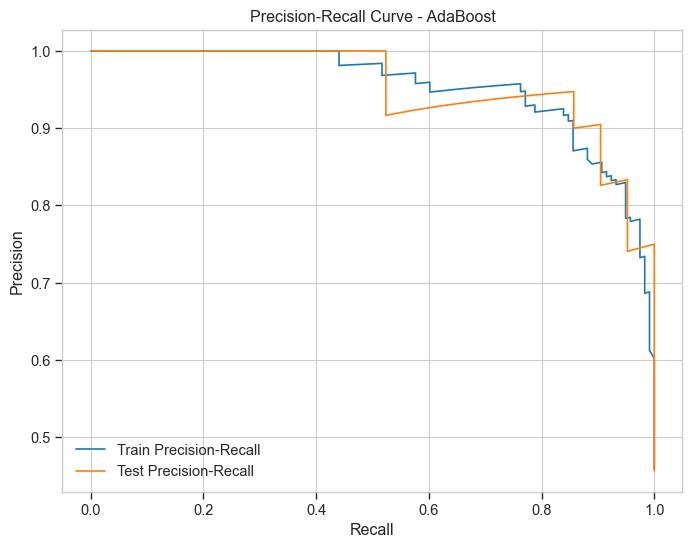

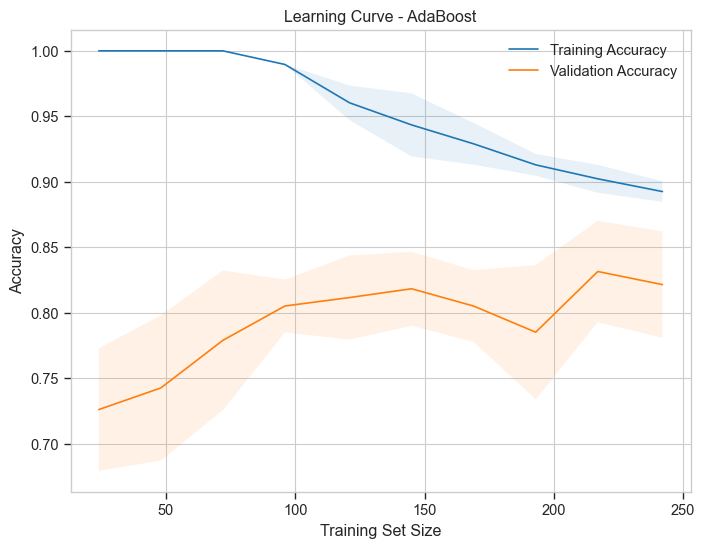


Feature Importance (AdaBoost):
chol: 0.1849
oldpeak: 0.1504
thalach: 0.1060
thal_3.0: 0.1003
ca_0.0: 0.0844
trestbps: 0.0705
age: 0.0656
cp_4: 0.0624
thal_6.0: 0.0523
sex: 0.0521
slope_2: 0.0349
restecg_0: 0.0223
ca_2.0: 0.0140
cp_3: 0.0000
restecg_1: 0.0000
restecg_2: 0.0000
slope_1: 0.0000
cp_2: 0.0000
slope_3: 0.0000
cp_1: 0.0000
exang: 0.0000
thal_7.0: 0.0000
fbs: 0.0000
ca_1.0: 0.0000
ca_3.0: 0.0000


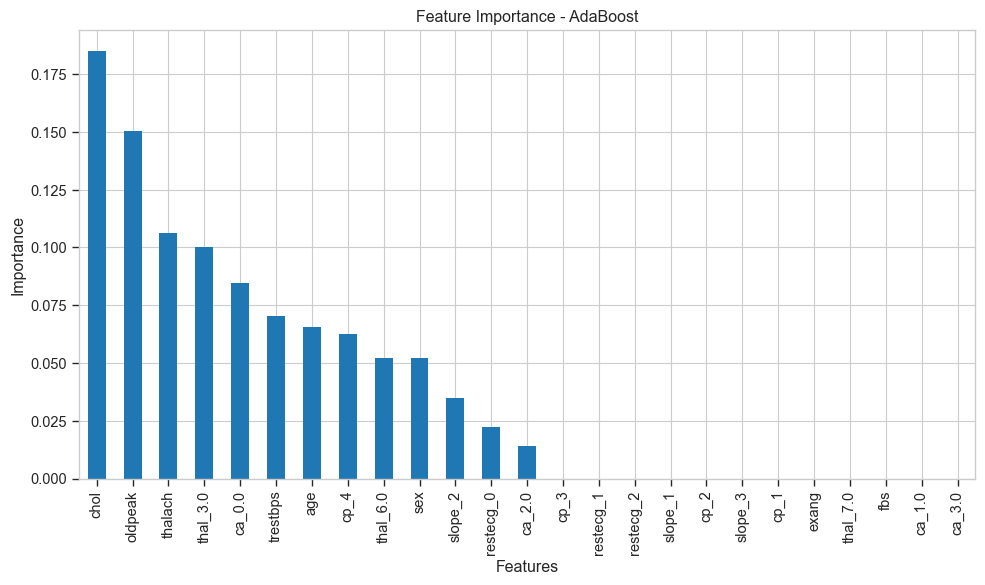

In [18]:
# --- AdaBoost Baseline ---
ada_model = AdaBoostClassifier(random_state=42)
evaluate_model(ada_model, X_train, X_test, y_train, y_test, 'AdaBoost')

## Extra Trees


=== Extra Trees Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1345 detik
Waktu Prediksi (Training Set): 0.0119 detik
Waktu Prediksi (Testing Set): 0.0087 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       139
           1       1.00      1.00      1.00       118

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Performance:
Accuracy: 0.8261
Precision: 0.7826
Recall: 0.8571
F1-Score: 0.8182

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        25
           1       0.78      0.86      0.82        21

    accuracy                           0.83        46
   macro avg       0.83  

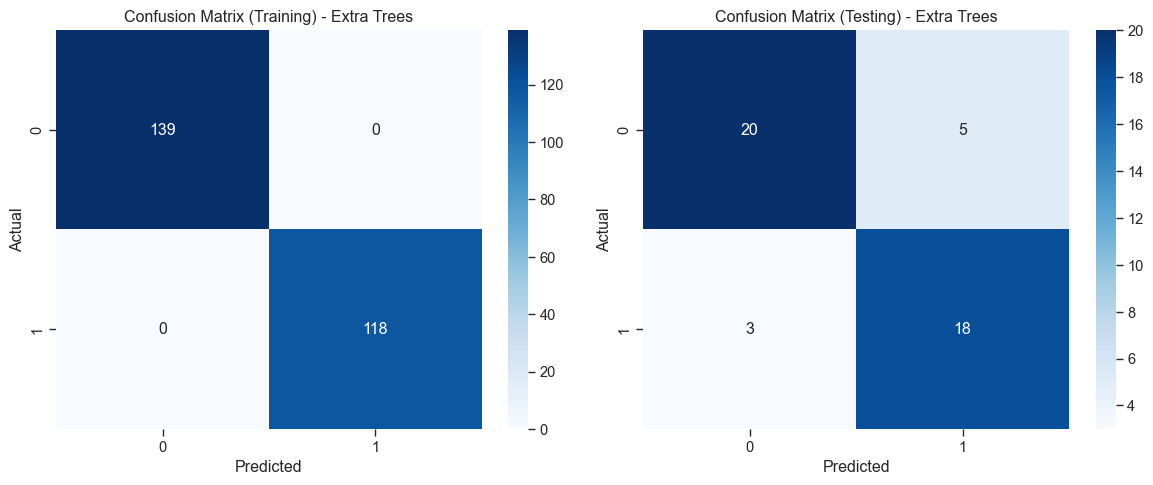

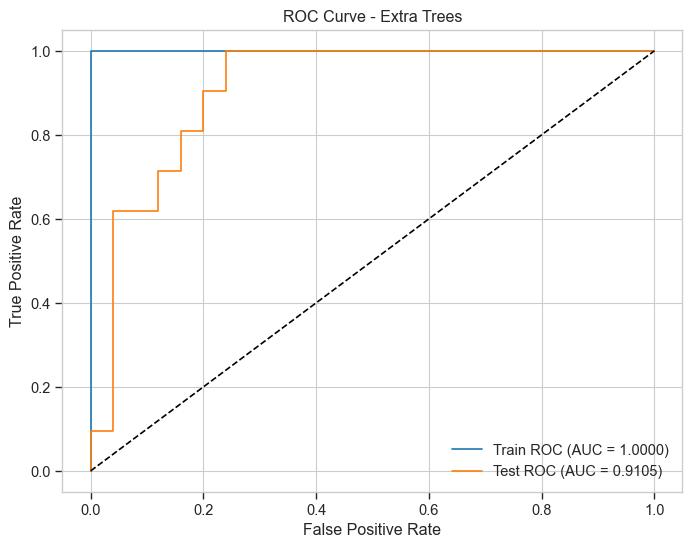

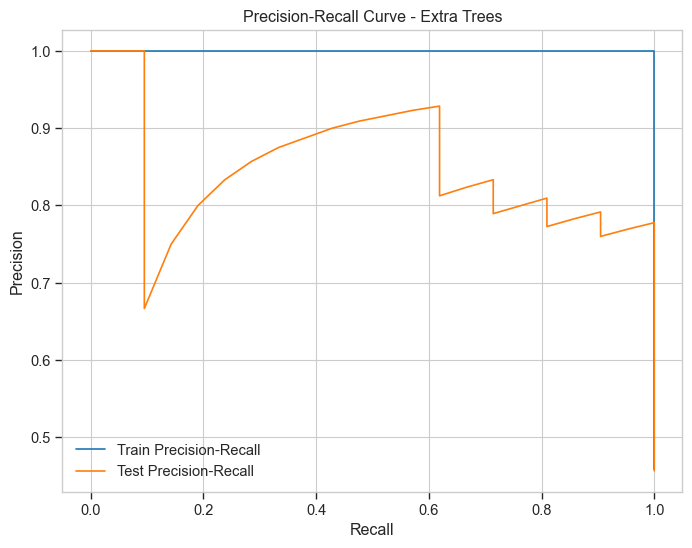

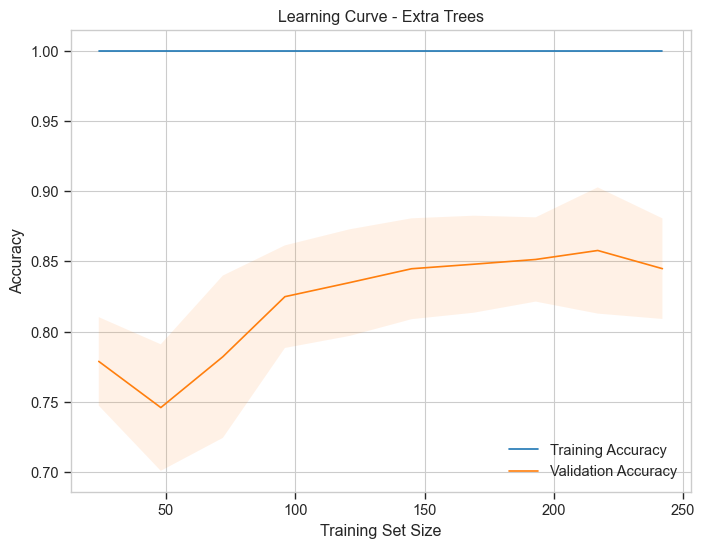


Feature Importance (Extra Trees):
thal_3.0: 0.1230
ca_0.0: 0.1096
thal_7.0: 0.1014
cp_4: 0.0899
age: 0.0562
oldpeak: 0.0512
chol: 0.0505
thalach: 0.0500
exang: 0.0468
trestbps: 0.0461
sex: 0.0336
slope_1: 0.0322
slope_2: 0.0311
ca_1.0: 0.0258
cp_3: 0.0249
restecg_2: 0.0206
restecg_0: 0.0200
cp_1: 0.0181
ca_3.0: 0.0163
cp_2: 0.0160
fbs: 0.0126
ca_2.0: 0.0115
thal_6.0: 0.0074
slope_3: 0.0052
restecg_1: 0.0001


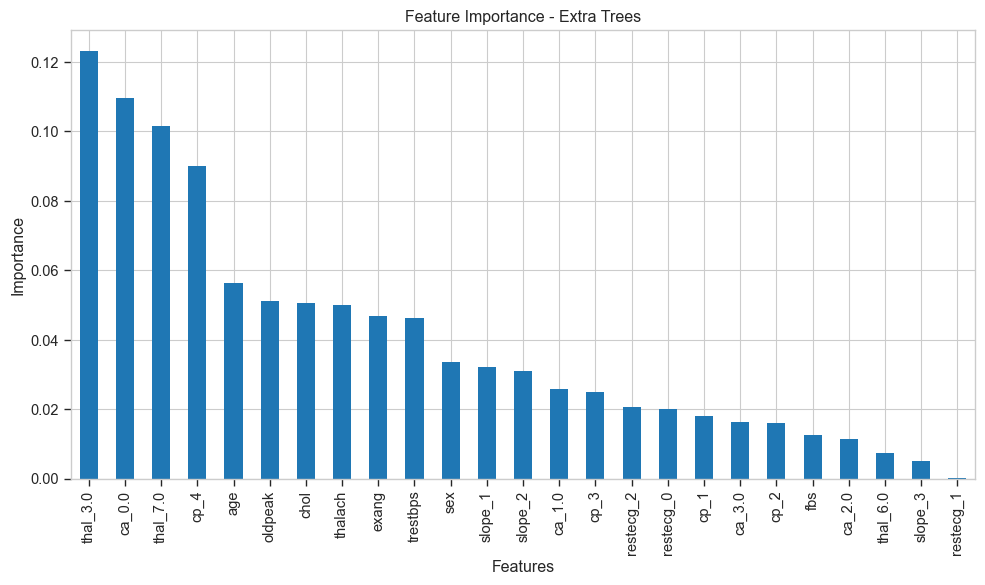

In [19]:
# --- Extra Trees Baseline ---
et_model = ExtraTreesClassifier(random_state=42)
evaluate_model(et_model, X_train, X_test, y_train, y_test, 'Extra Trees')

## XGBoost

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0994 detik
Waktu Prediksi (Training Set): 0.0060 detik
Waktu Prediksi (Testing Set): 0.0057 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       139
           1       1.00      1.00      1.00       118

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Performance:
Accuracy: 0.8261
Precision: 0.7826
Recall: 0.8571
F1-Score: 0.8182

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        25
           1       0.78      0.86      0.82        21

    accuracy                           0.83        46
   macro avg       0.83      

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: U


Cross-Validation (5-Fold) Accuracy:
Scores: [0.8689 0.8525 0.7377 0.7167 0.8167]
Mean Accuracy: 0.7985 ± 0.0610


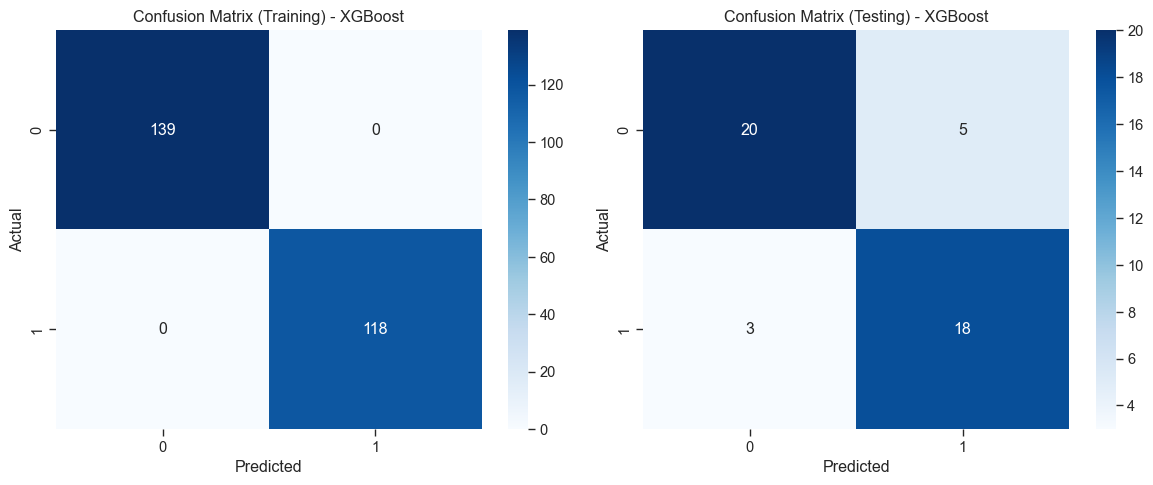

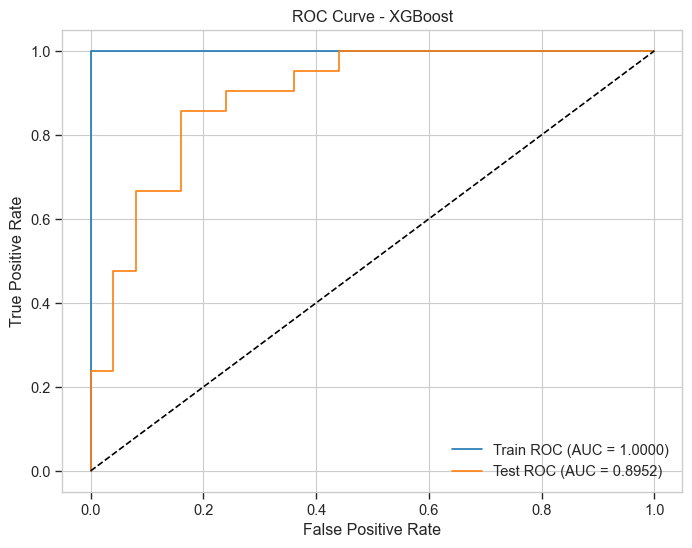

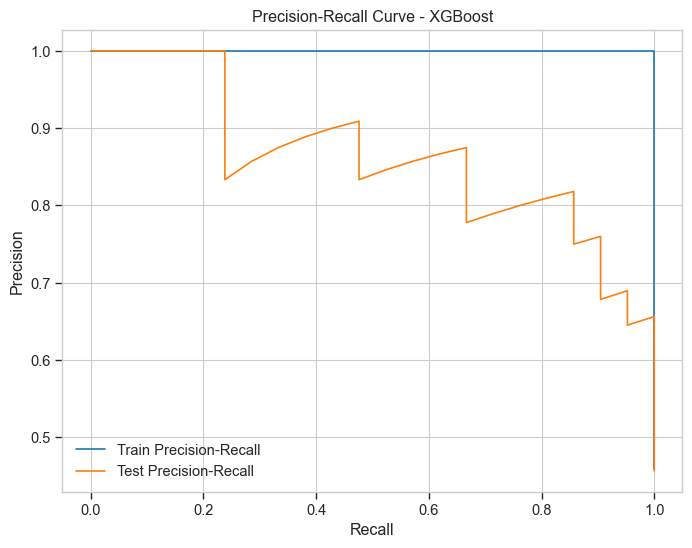

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: U

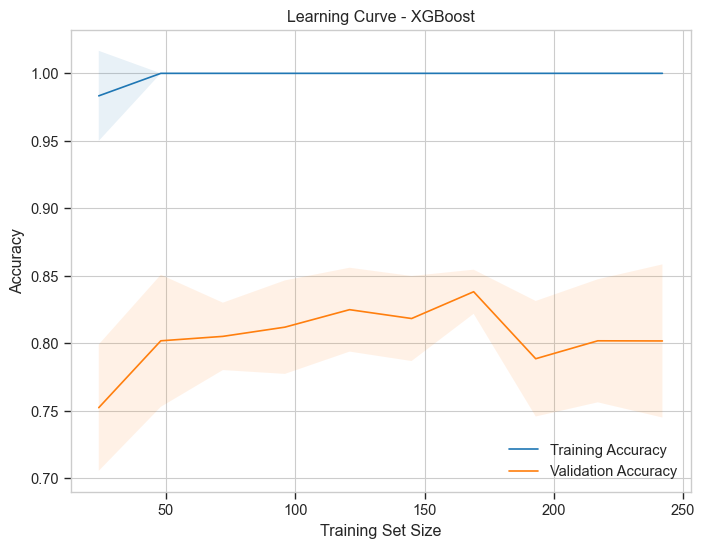


Feature Importance (XGBoost):
thal_3.0: 0.4916
thal_7.0: 0.0931
ca_0.0: 0.0680
cp_4: 0.0469
cp_1: 0.0373
thal_6.0: 0.0280
ca_2.0: 0.0269
exang: 0.0267
slope_1: 0.0263
sex: 0.0233
oldpeak: 0.0158
age: 0.0152
slope_2: 0.0151
cp_2: 0.0138
restecg_0: 0.0138
trestbps: 0.0136
thalach: 0.0128
chol: 0.0109
cp_3: 0.0100
fbs: 0.0098
restecg_2: 0.0012
restecg_1: 0.0000
slope_3: 0.0000
ca_1.0: 0.0000
ca_3.0: 0.0000


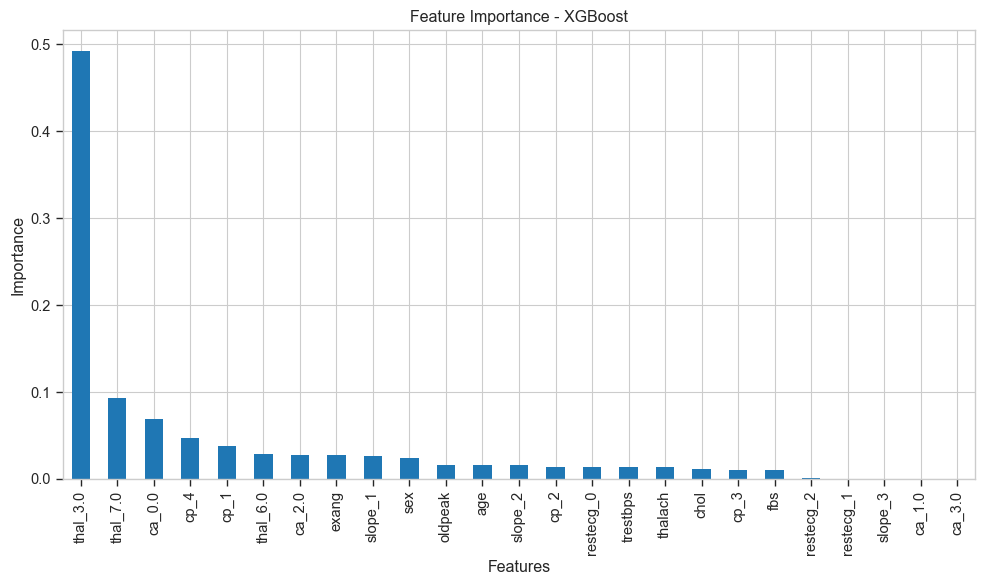

In [20]:
# --- XGBoost Baseline ---
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb_model, X_train, X_test, y_train, y_test, 'XGBoost')

## LigthGBM

[LightGBM] [Info] Number of positive: 118, number of negative: 139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 257, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459144 -> initscore=-0.163789
[LightGBM] [Info] Start training from score -0.163789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

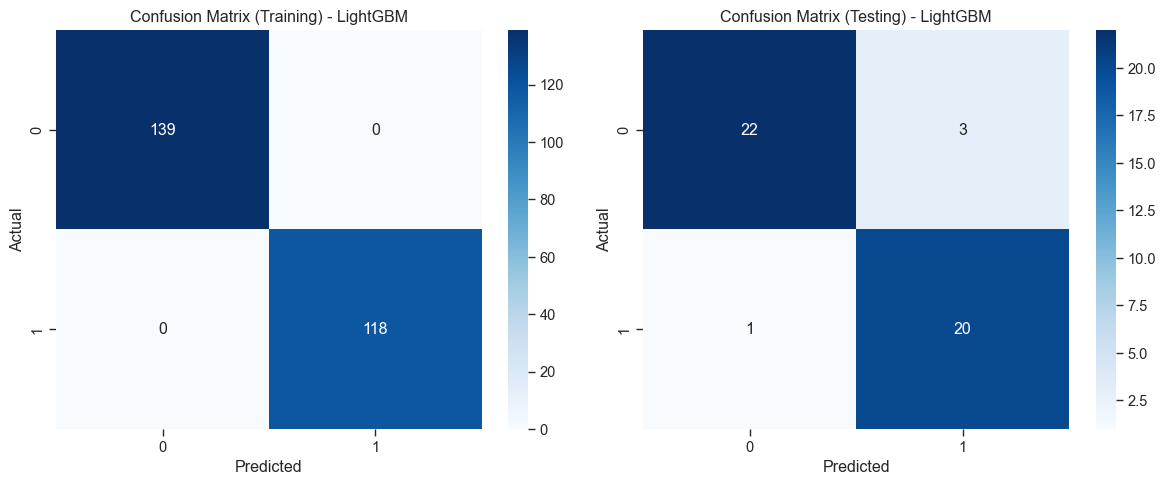

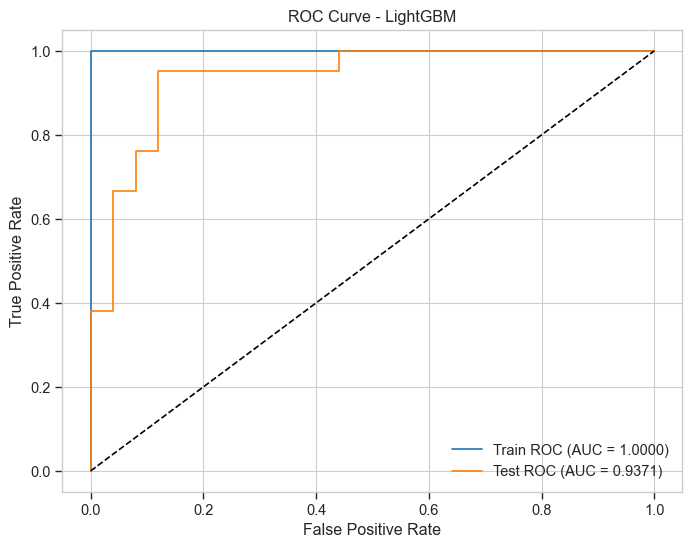

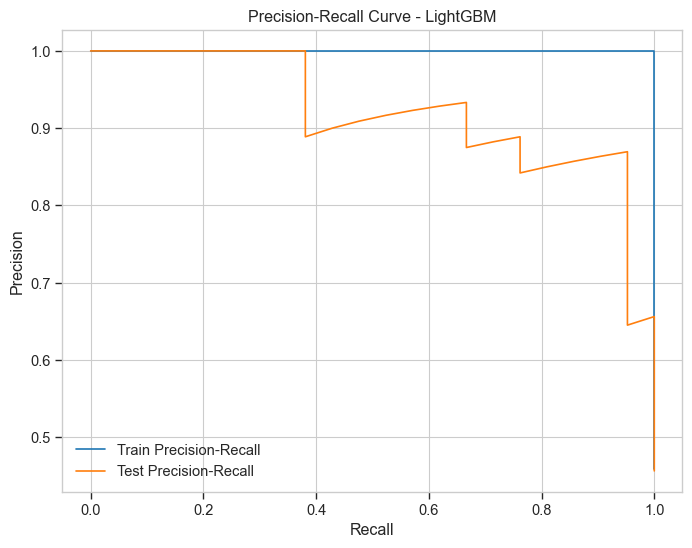

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 11, number of negative: 13
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458333 -> initscore=-0.167054
[LightGBM] [Info] Start training from score -0.167054
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because t

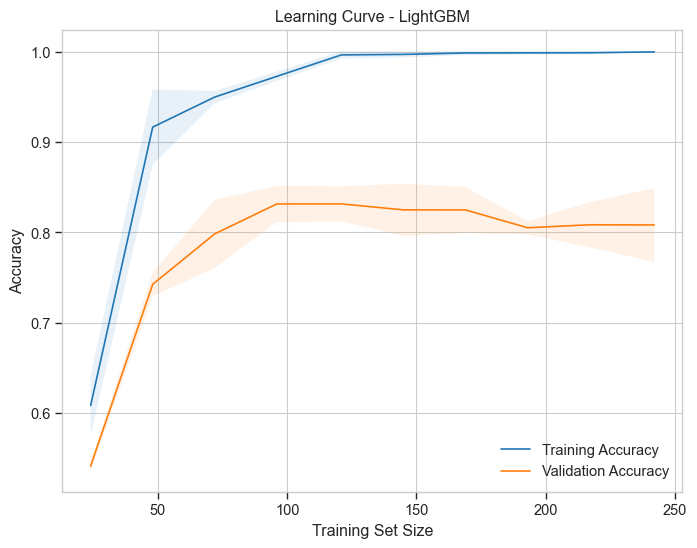


Feature Importance (LightGBM):
age: 173.0000
chol: 129.0000
thalach: 115.0000
oldpeak: 105.0000
trestbps: 94.0000
ca_0.0: 62.0000
cp_4: 43.0000
sex: 42.0000
thal_7.0: 37.0000
slope_2: 30.0000
restecg_0: 28.0000
thal_3.0: 21.0000
exang: 18.0000
restecg_2: 9.0000
slope_1: 9.0000
ca_1.0: 6.0000
ca_2.0: 6.0000
cp_3: 3.0000
fbs: 3.0000
cp_1: 2.0000
cp_2: 0.0000
restecg_1: 0.0000
slope_3: 0.0000
thal_6.0: 0.0000
ca_3.0: 0.0000


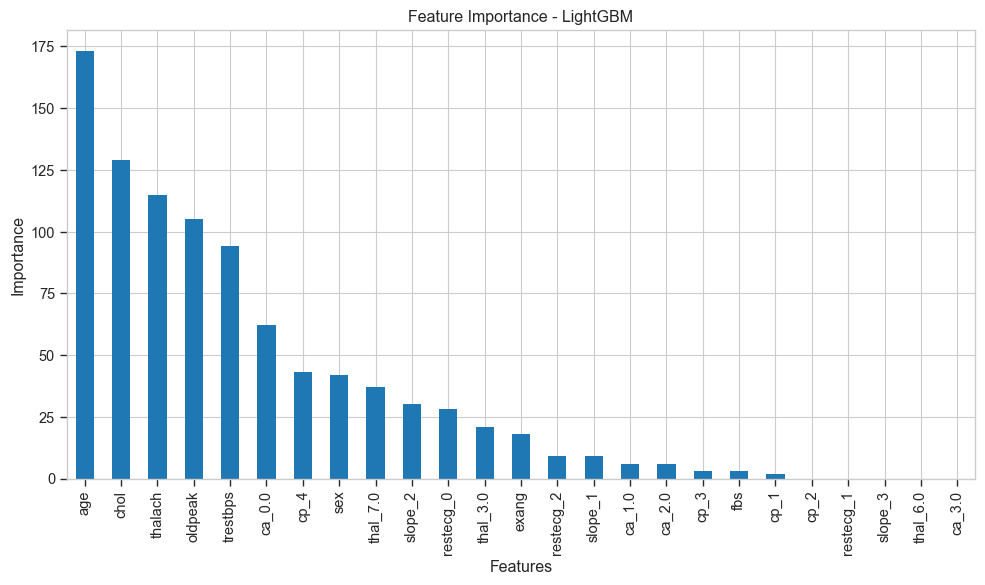

In [21]:
# --- LightGBM Baseline ---
lgb_model = lgb.LGBMClassifier(random_state=42)
evaluate_model(lgb_model, X_train, X_test, y_train, y_test, 'LightGBM')

## CatBoost


=== CatBoost Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 2.8147 detik
Waktu Prediksi (Training Set): 0.0023 detik
Waktu Prediksi (Testing Set): 0.0026 detik

Training Performance:
Accuracy: 0.9961
Precision: 1.0000
Recall: 0.9915
F1-Score: 0.9957

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       139
           1       1.00      0.99      1.00       118

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Performance:
Accuracy: 0.8913
Precision: 0.8333
Recall: 0.9524
F1-Score: 0.8889

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        25
           1       0.83      0.95      0.89        21

    accuracy                           0.89        46
   macro avg       0.89     

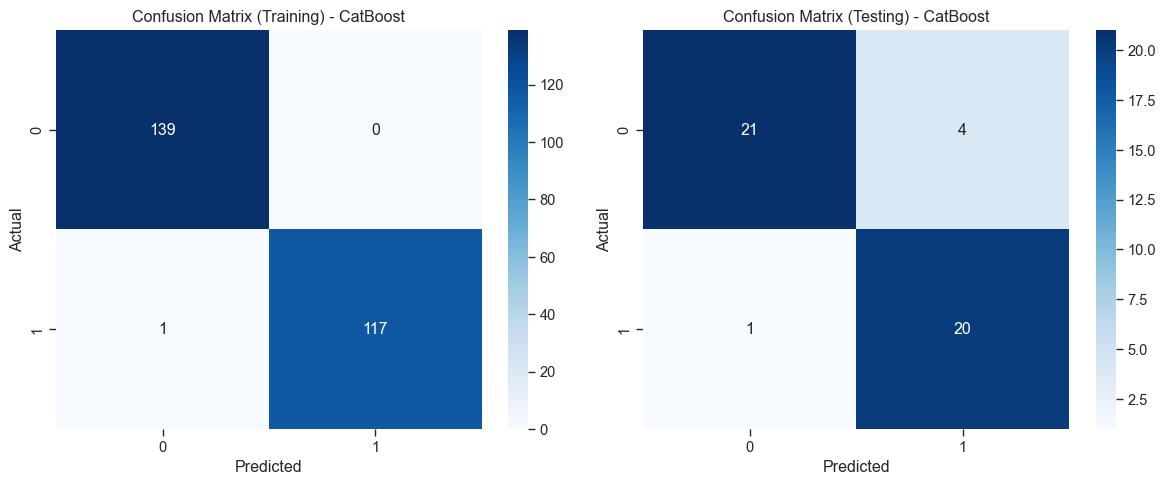

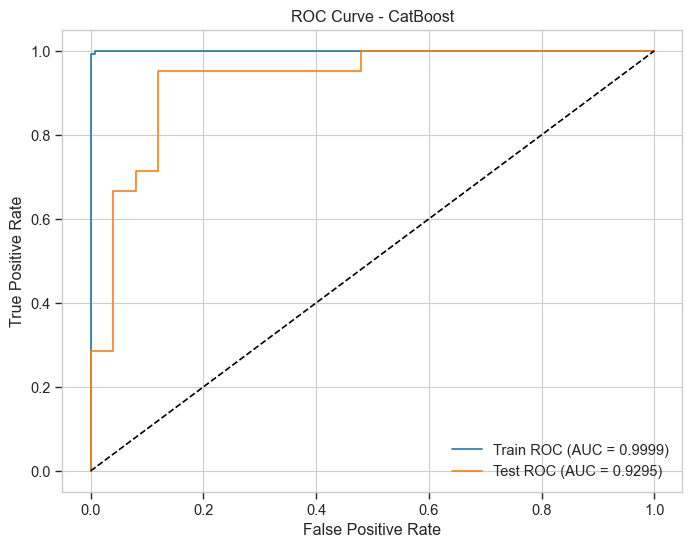

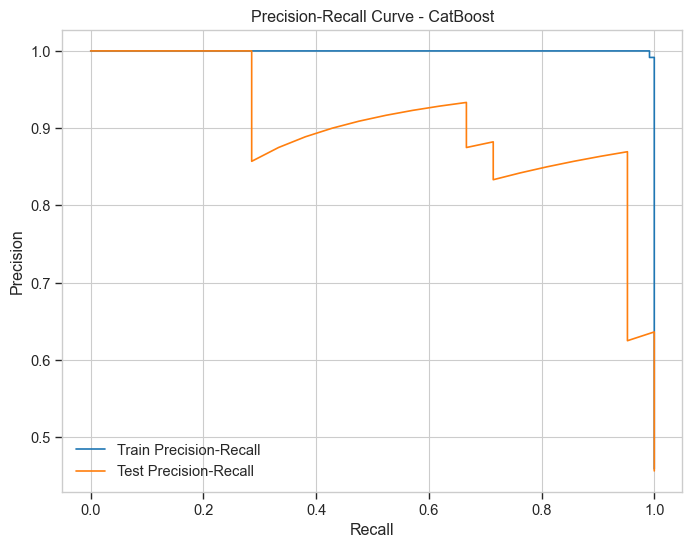

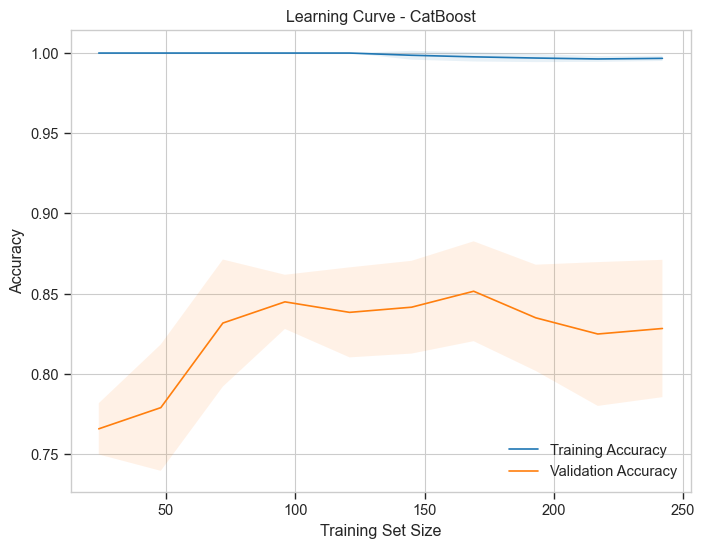


Feature Importance (CatBoost):
ca_0.0: 12.6150
age: 10.0358
thal_7.0: 8.8851
oldpeak: 8.5562
chol: 8.0916
cp_4: 7.7918
thal_3.0: 7.1553
thalach: 6.5259
trestbps: 5.6134
sex: 5.0936
exang: 2.6060
cp_3: 2.4531
slope_1: 2.2994
restecg_2: 2.2765
slope_2: 2.0935
ca_1.0: 2.0470
restecg_0: 1.9208
cp_1: 1.1264
cp_2: 0.8958
ca_2.0: 0.5393
ca_3.0: 0.4681
fbs: 0.4297
slope_3: 0.2464
thal_6.0: 0.2316
restecg_1: 0.0027


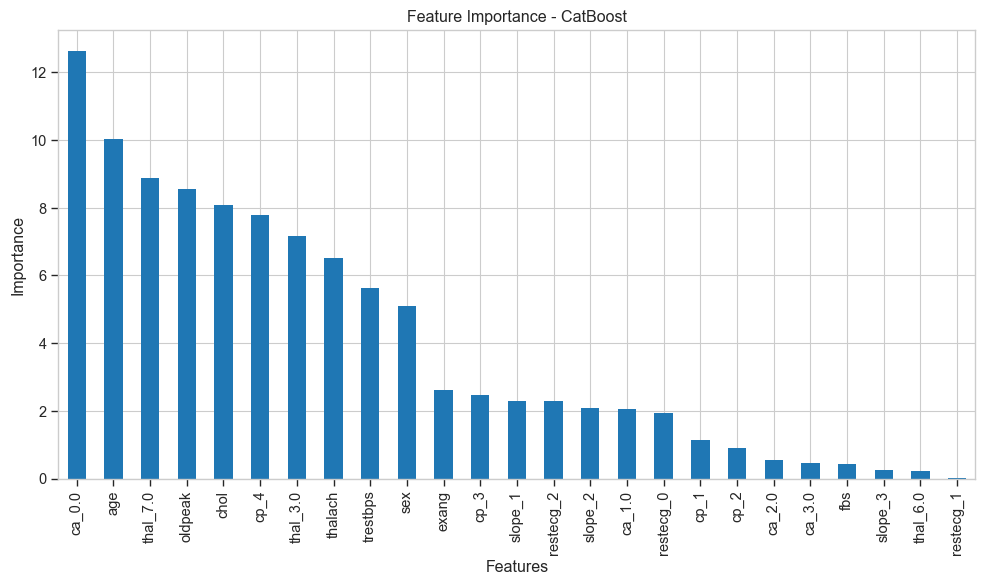

In [22]:
# --- CatBoost Baseline ---
cb_model = cb.CatBoostClassifier(random_state=42, verbose=0)
evaluate_model(cb_model, X_train, X_test, y_train, y_test, 'CatBoost')

## MLP


=== Neural Network (MLP) Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.7625 detik
Waktu Prediksi (Training Set): 0.0005 detik
Waktu Prediksi (Testing Set): 0.0002 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       139
           1       1.00      1.00      1.00       118

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257


Testing Performance:
Accuracy: 0.8261
Precision: 0.7600
Recall: 0.9048
F1-Score: 0.8261

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.90      0.76      0.83        25
           1       0.76      0.90      0.83        21

    accuracy                           0.83        46
   macro avg    

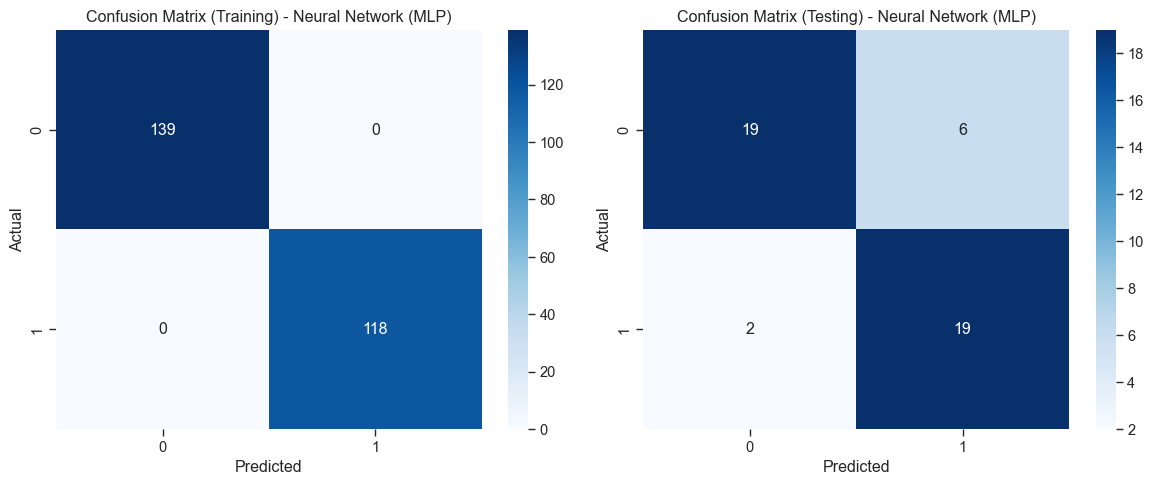

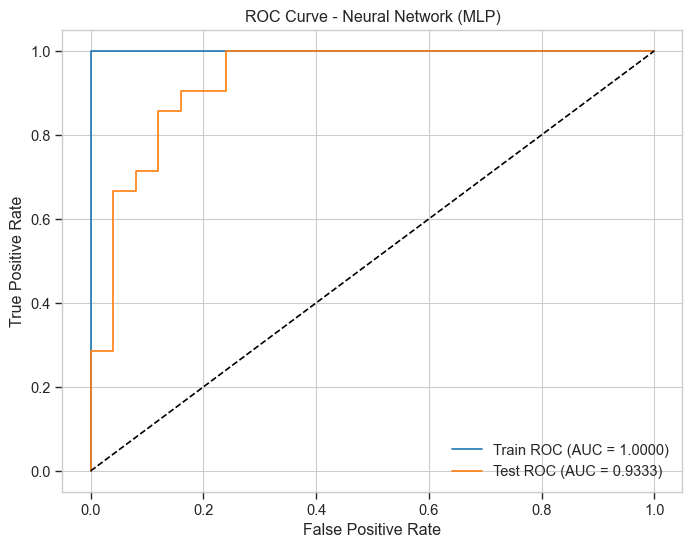

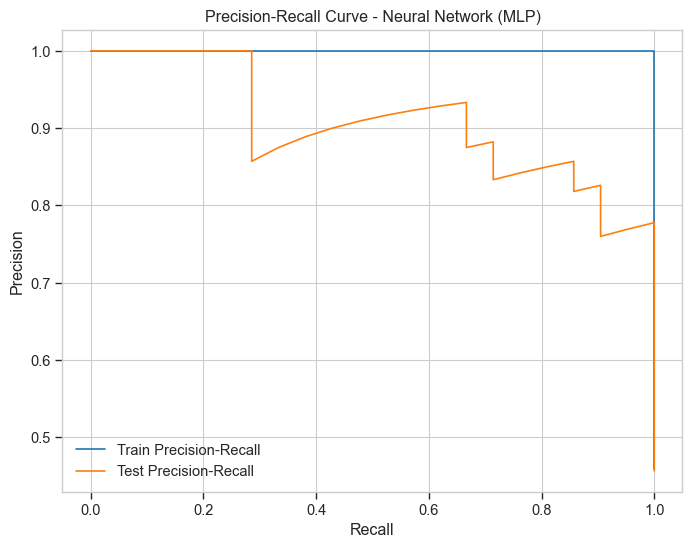

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Ma

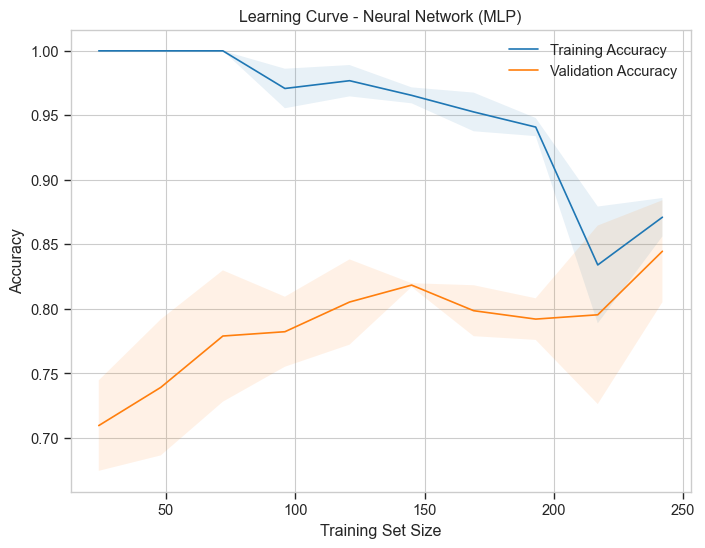

In [40]:
# --- Scale Data for Neural Network ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Neural Network (MLP) Baseline ---
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
evaluate_model(mlp_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Neural Network (MLP)')